## Current Rebalancing Process

### Step 1: AA comparison in Databricks.


1.  First, the AA comparison is done in DataBricks.
2.  Members are stratfied into 7 demand buckets, ranging from 0 to 2399
3.  Any demand greater than 2400 is considered an outlier, and removed from the analysis.
4. The `PERCENT_RANK` function is used to rank users based on their demand (spending) across different “demand buckets” (like 0-50, 50-100, etc.).
5. However, the current settings apply a fixed percentage cutoff (`<= 1`), meaning it takes the entire user set in these ranges for both control and test groups.


In [ ]:
SELECT
  test_control
  -- primary metrics on incremental revenue: conversion rate, average demand per purchaser
  ,COUNT(DISTINCT upm_id) AS total_members
  ,COUNT(DISTINCT upm_id_buyer) AS buying_members
  ,COUNT(DISTINCT upm_id_buyer) / COUNT(DISTINCT upm_id) AS conversion_rate
  ,AVG(demand) AS avg_demand
  ,STDDEV(demand) AS std_demand

  -- secondary metrics ON order double click
  ,SUM(demand) / SUM(orders) AS AOV
  ,SUM(demand) / SUM(units) AS AUR
  ,SUM(units) / SUM(orders) AS UPT


FROM demand_bucket db
WHERE (demand < 2400 OR demand IS NULL)  -- remove outliers
AND test_control != 'na'
-- To rebalance, paste text block from template in place of defaults
AND ((test_control = 'control' and (demand > 0 and demand <= 50) and PERCENT_RANK <= 1)
OR (test_control = 'control' and (demand > 50 and demand <= 100) and PERCENT_RANK <= 1)
OR (test_control = 'control' and (demand > 100 and demand <= 200) and PERCENT_RANK <= 1)
OR (test_control = 'control' and (demand > 200 and demand <= 500) and PERCENT_RANK <= 1)
OR (test_control = 'control' and (demand > 500 and demand <= 1000) and PERCENT_RANK <= 1)
OR (test_control = 'control' and (demand > 1000) and PERCENT_RANK <= 1)
OR (test_control = 'control' and (demand = 0 or demand is null) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand >0 and demand <= 50) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 50 and demand <= 100) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 100 and demand <= 200) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 200 and demand <= 500) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 500 and demand <= 1000) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 1000) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand = 0 or demand is null) and PERCENT_RANK <= 1)
)

GROUP BY 1
ORDER BY 1 DESC;

### Step 2: AA comparison in Excel


1.  The resulting AA comaprison table from Databricks is [pasted into Excel](https://nike.ent.box.com/folder/159196048910?s=rleparlsqxinvaa8m93dipsuaxk1d4fc).

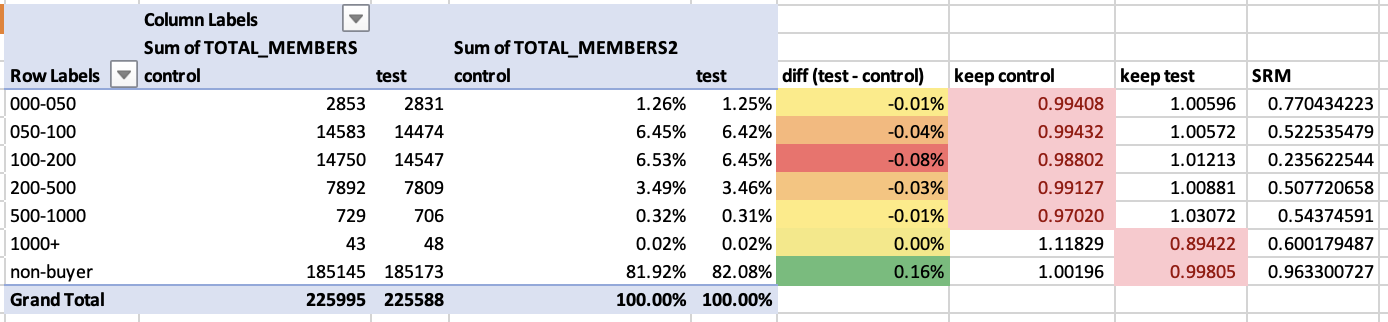

2. The primary difference here is that the `PERCENT_RANK` cutoffs are adjusted.      
    - For example:
     - Instead of including all users in the 0-50 demand range (i.e., `PERCENT_RANK <= 1`), it now only includes a slightly smaller percentage (`PERCENT_RANK <= 0.99408` for the control group).
3. This adjustment is designed to rebalance the dataset and remove a small number of users from specific demand ranges.

### Step 3: Add updated code to Databricks

The updated demand buckets are then added back into the DataBricks code to create a "balanced" dataset for analysis.

In [ ]:
SELECT
  test_control
  -- primary metrics on incremental revenue: conversion rate, average demand per purchaser
  ,COUNT(DISTINCT upm_id) AS total_members
  ,COUNT(DISTINCT upm_id_buyer) AS buying_members
  ,COUNT(DISTINCT upm_id_buyer) / COUNT(DISTINCT upm_id) AS conversion_rate
  ,AVG(demand) AS avg_demand
  ,STDDEV(demand) AS std_demand

  -- secondary metrics ON order double click
  ,SUM(demand) / SUM(orders) AS AOV
  ,SUM(demand) / SUM(units) AS AUR
  ,SUM(units) / SUM(orders) AS UPT


FROM demand_bucket db
WHERE (demand < 2400 OR demand IS NULL)  -- remove outliers
AND test_control != 'na'
-- To rebalance, paste text block from template in place of defaults
AND ((test_control = 'control' and (demand > 0 and demand <= 50) and PERCENT_RANK <= 0.99408)
OR (test_control = 'control' and (demand > 50 and demand <= 100) and PERCENT_RANK <= 0.99432)
OR (test_control = 'control' and (demand > 100 and demand <= 200) and PERCENT_RANK <= 0.98802)
OR (test_control = 'control' and (demand > 200 and demand <= 500) and PERCENT_RANK <= 0.99127)
OR (test_control = 'control' and (demand > 500 and demand <= 1000) and PERCENT_RANK <= 0.9702)
OR (test_control = 'control' and (demand > 1000) and PERCENT_RANK <= 1)
OR (test_control = 'control' and (demand = 0 or demand is null) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand >0 and demand <= 50) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 50 and demand <= 100) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 100 and demand <= 200) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 200 and demand <= 500) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 500 and demand <= 1000) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 1000) and PERCENT_RANK <= 0.89422)
OR (test_control = 'test' and (demand = 0 or demand is null) and PERCENT_RANK <= 0.99805)
)

GROUP BY 1
ORDER BY 1 DESC;

### Summary of Overall Process:
- Initially, the A/B test data is extracted from Databricks, including key metrics like conversion rates, average demand, etc.
- The team checks the balance between the test and control groups by evaluating demand in different ranges.
- If there’s imbalance, the team adjusts the dataset by removing users in certain demand buckets (using Excel to decide which users to remove) to create a more balanced comparison.
- The final step involves modifying the SQL code to include the revised `PERCENT_RANK` thresholds, ensuring balanced test and control groups before calculating the metrics again.

## NEW Rebalancing Strategy

Assessing the need for rebalancing a dataset, especially for a metric like "Demand," involves a few steps to understand the underlying distribution and variability between groups (e.g., test vs. control).

Here's how I would approach it:


### 0. Perform Basic Descriptive Statistics
  * Calculate mean, median, mode, standard deviation for Demand in both groups.
  * Visualize the distributions of Demand in both groups using histograms, box plots, or density plots.

### 1. Understanding the Metric and Its Importance
- **What does "Demand" represent in our dataset?**
  * Total sales per buyer
- **How critical is "Demand" for our analysis?**
  * Demand is the main outcome, or primary kpi. The audience is balanced on this metric.
  * Conversion rate is the secondary measure.

### 2. Preliminary Data Exploration
- **What is the scale and range of "Demand"?**
  * It's continuous.
  * Max value is .
  * Min value is
  * Scale is
  * Range is
- **Are there any known outliers or extreme values in the "Demand" data?**
  * We condsider anything above 2400 an outlier.

### 3. Distribution Analysis
- **Does "Demand" follow a known distribution in each group?** (*Initial plots (histogram, boxplot) can give a visual cue. Formal tests (Shapiro-Wilk for normality) can provide statistical evidence.*)
  * Histogram shows a right tailed, bimodal distribution for both groups.
  * Shapiro Wilk value =
- **Is there a significant difference in the distribution shapes between groups?** (*This can be initially assessed visually, then tested with KS or Anderson-Darling tests*).
  * KS value =
  * AD value =

### 4. Variability Assessment
- **How comparable are the variances between the test and control groups?** (*Levene's or Brown-Forsythe tests can assess the equality of variances, an important aspect of balance.*)
  * Levene's test value =
  * Brown-Forsythe test value =


### 5. Sample Size and Power Analysis
- **Are the sample sizes between the groups comparable and sufficient?**
  * test group size =
  * control group size =

- **Have we conducted or do we need a power analysis for "Demand"?** This can inform whether the current sample sizes are adequate for detecting a meaningful difference between groups.

### 6. Assessing the Need for Rebalancing
Based on the above analyses, we can decide if rebalancing is necessary:
- **If distributions are significantly different**,
  * consider techniques like matching, stratification, or weighting to balance the groups.
- **If variances are unequal**,
  * transformations or non-parametric tests might be preferred.
- **If sample sizes are imbalanced**,
  * consider collecting more data, if possible, or applying statistical techniques that are less sensitive to imbalance.

## Specific Questions to Further Inform Strategy:
1. **Are there covariates or confounding variables that should be considered?**
  * Balancing might not only be about the primary metric (demand) but also about ensuring that important covariates are equally represented across groups.
2. **What is the goal of rebalancing?**
  * Improve test accuracy, ensure fairness in comparison, etc.
3. **Are there constraints or limitations in the data collection process that might affect rebalancing efforts?**
4. **Are we open to using statistical techniques like propensity score matching, or do we prefer simpler methods like stratification or oversampling?**

Based on the team's responses to these questions,  tailor the approach to ensure that the dataset is appropriately balanced for analysis.

## Perform Basic Descriptive Statistics

### Step 1: Create a sample dataset
Create a sample dataset that has a similar distribution to Nike demand data.

In [ ]:
# Adjusting the dataset to have more pronounced right skewness with modes around 75 and 125

# Generate a fake dataset
import numpy as np
import pandas as pd

# Seed for reproducibility
np.random.seed(42)

# Generate 1000 records
num_records = 1000

# Generate upm_id as a unique identifier for each record
upm_id = np.arange(1, num_records + 1)

# Generate a right-skewed, bimodal distribution for demand with modes at 150 and 157
mode1 = np.random.normal(loc=150, scale=10, size=int(num_records * 0.52))  # 52% of data around 150
mode2 = np.random.normal(loc=157, scale=70, size=int(num_records * 0.48))  # 48% of data around 157
demand = np.concatenate([mode1, mode2])
np.random.shuffle(demand)  # Shuffle to mix the modes well

# Ensure all demand values are positive
demand = np.abs(demand)

# Generate a binary buyer column, where about 20% are buyers
buyer = np.random.choice([0, 1], size = num_records, p=[0.8, 0.2])

# Generate test_control group, imbalanced with more control than test
test_control = np.random.choice(['test', 'control'], size=num_records, p=[0.49, 0.51])

# Create the DataFrame
df_aa = pd.DataFrame({
    'upm_id': upm_id,
    'demand': demand,
    'buyer': buyer,
    'test_control': test_control
})

# Display the first few rows of the dataset
df_aa.head(), df_aa.describe()




(   upm_id      demand  buyer test_control
 0       1   55.326383      0         test
 1       2  156.141667      0      control
 2       3  141.428424      0      control
 3       4  150.758046      0         test
 4       5  157.384666      0         test,
             upm_id       demand        buyer
 count  1000.000000  1000.000000  1000.000000
 mean    500.500000   156.029575     0.214000
 std     288.819436    59.238220     0.410332
 min       1.000000     3.084822     0.000000
 25%     250.750000   137.841476     0.000000
 50%     500.500000   150.994918     0.000000
 75%     750.250000   166.973684     0.000000
 max    1000.000000   393.914386     1.000000)

#### Generate fake dataset using `np.random.default_rng()`

In [ ]:
import numpy as np
import pandas as pd

# Use a random number generator (RNG) for reproducibility
rng = np.random.default_rng(12)  # Create a Generator instance with seed 42

# Generate 1000 records
num_records = 1000

# Generate upm_id as a unique identifier for each record
upm_id = np.arange(1, num_records + 1)

# Generate a right-skewed, bimodal distribution for demand with more pronounced skew
# We use log-normal to create a right skew, one around 150, one around 157
mode1 = rng.lognormal(mean=np.log(150), sigma=0.3, size=int(num_records * 0.52))  # 52% around 150
mode2 = rng.lognormal(mean=np.log(157), sigma=0.5, size=int(num_records * 0.48))  # 48% around 157
demand = np.concatenate([mode1, mode2])
rng.shuffle(demand)  # Shuffle to mix the modes well

# Generate a binary buyer column, where about 20% are buyers
buyer = rng.choice([0, 1], size=num_records, p=[0.8, 0.2])

# Generate test_control group, imbalanced with more control than test
test_control = rng.choice(['test', 'control'], size=num_records, p=[0.49, 0.51])

# Create the DataFrame
df_aa = pd.DataFrame({
    'upm_id': upm_id,
    'demand': demand,
    'buyer': buyer,
    'test_control': test_control
})

# Display the first few rows of the dataset
df_aa.head(), df_aa.describe()


(   upm_id      demand  buyer test_control
 0       1  158.798539      0      control
 1       2   59.665870      0         test
 2       3  258.113581      0      control
 3       4  123.194361      0      control
 4       5  237.352893      0         test,
             upm_id       demand       buyer
 count  1000.000000  1000.000000  1000.00000
 mean    500.500000   167.947723     0.19300
 std     288.819436    76.584448     0.39485
 min       1.000000    38.640126     0.00000
 25%     250.750000   119.788399     0.00000
 50%     500.500000   154.063600     0.00000
 75%     750.250000   194.629098     0.00000
 max    1000.000000   656.825424     1.00000)

###  Step 2: Get the measures of central tendency

In [ ]:
# Get the measures of central tendency, range, etc

import pandas as pd
import numpy as np
import statistics

# Separate the test and control groups
test_group_aa = df_aa[df_aa['test_control'] == 'test']
control_group_aa = df_aa[df_aa['test_control'] == 'control']

def calculate_central_tendency(numbers):
    mean = statistics.mean(numbers)
    median = statistics.median(numbers)
    try:
        mode = statistics.mode(numbers)
    except statistics.StatisticsError:
        mode = "No unique mode found"
    max_value = max(numbers)
    min_value = min(numbers)
    range_value = max_value - min_value
    return mean, median, mode, max_value, min_value, range_value

# Select the 'demand' column for the test group to calculate its statistics
numbers_test = test_group_aa['demand'].tolist()

mean, median, mode, max_value, min_value, range_value = calculate_central_tendency(numbers_test)

print("Test Group 'demand' Statistics:")
print("Mean:", mean)
print("Median:", median)
print("Mode:", mode)
print("Max value:", max_value)
print("Min value:", min_value)
print("Range:", range_value)

# Repeat the process for the control group if needed
numbers_control = control_group_aa['demand'].tolist()

mean_c, median_c, mode_c, max_value_c, min_value_c, range_value_c = calculate_central_tendency(numbers_control)

print("\nControl Group 'demand' Statistics:")
print("Mean:", mean_c)
print("Median:", median_c)
print("Mode:", mode_c)
print("Max value:", max_value_c)
print("Min value:", min_value_c)
print("Range:", range_value_c)


Test Group 'demand' Statistics:
Mean: 152.52828130622018
Median: 151.13517345251248
Mode: 77.92052017396674
Max value: 333.88526981115353
Min value: 3.0835830365942627
Range: 330.80168677455924

Control Group 'demand' Statistics:
Mean: 156.8550626125708
Median: 151.17327383308782
Mode: 156.14166700043424
Max value: 341.26674453861733
Min value: 2.220528369448033
Range: 339.04621616916927


### Step 3: Distribution Analysis
  - Visualize Distribution for Demand
  - Visualize Distribution for Conversion
  - Run Shapiro-Wilk test for normality



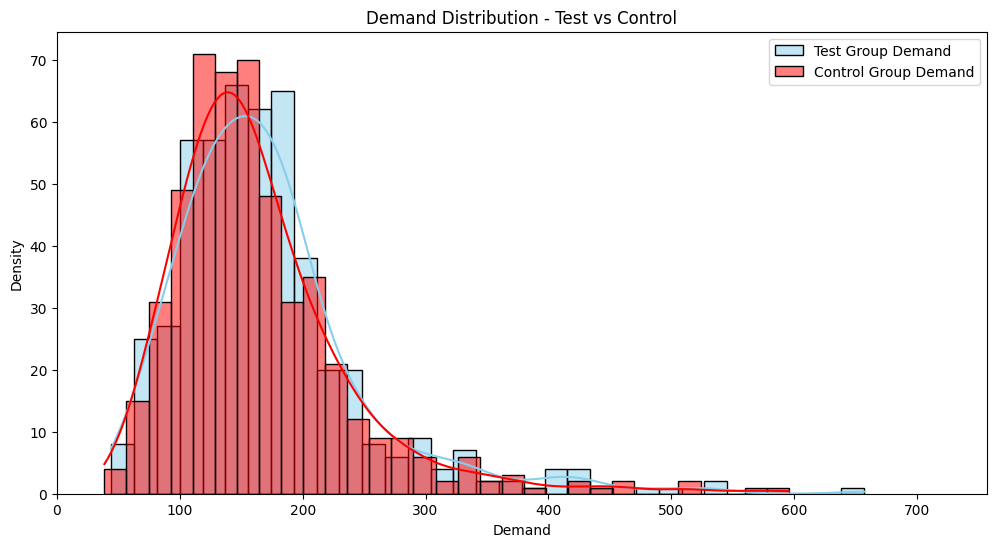

In [ ]:
## Demand

# %python
import matplotlib.pyplot as plt
import seaborn as sns

# Separate the test and control groups
test_group_aa = df_aa[df_aa['test_control'] == 'test']
control_group_aa = df_aa[df_aa['test_control'] == 'control']

# Plotting Demand Distribution
plt.figure(figsize=(12, 6))
sns.histplot(test_group_aa['demand'].dropna(), color="skyblue", label="Test Group Demand", kde=True)
sns.histplot(control_group_aa['demand'].dropna(), color="red", label="Control Group Demand", kde=True)
plt.title('Demand Distribution - Test vs Control')
plt.xlabel('Demand')
plt.ylabel('Density')
plt.xlim(0, df_aa['demand'].max()+ 100)
plt.legend()
plt.show()

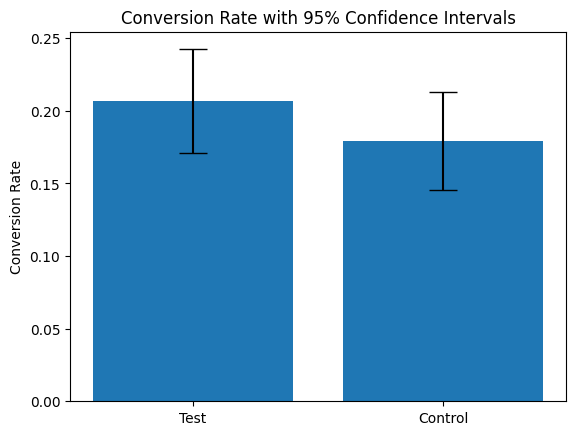

In [ ]:
# Conversion through Confidence Intervals


"""
The proportion_confint function calculates confidence intervals for each group's conversion rate.

These intervals are then plotted as error bars on a bar chart, giving a clearer picture of the data's variability
and how the groups compare.
"""

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# Function to calculate the confidence interval
def proportion_confint(count, nobs, alpha=0.05, method='normal'):
    quantile = stats.norm.ppf(1 - alpha / 2.)
    center = count / nobs
    error = quantile * np.sqrt(center * (1 - center) / nobs)
    return center - error, center + error

# Calculating conversion rate and confidence intervals
test_success = test_group_aa['buyer'].sum()
test_total = test_group_aa['buyer'].count()
test_cr, test_ci_lower, test_ci_upper = test_success / test_total, *proportion_confint(test_success, test_total)

control_success = control_group_aa['buyer'].sum()
control_total = control_group_aa['buyer'].count()
control_cr, control_ci_lower, control_ci_upper = control_success / control_total, *proportion_confint(control_success, control_total)

# Plotting
fig, ax = plt.subplots()
ax.bar(['Test', 'Control'], [test_cr, control_cr], yerr=[[test_cr - test_ci_lower, control_cr - control_ci_lower],[test_ci_upper - test_cr, control_ci_upper - control_cr]], capsize=10)
ax.set_ylabel('Conversion Rate')
ax.set_title('Conversion Rate with 95% Confidence Intervals')
plt.show()



In [ ]:
# Shapiro Wilks Test

3. Is there a significant difference in the distribution shapes between groups?

  #### Kolmogorov-Smirnov test

  * The primary focus of the KS test is to determine if two samples are drawn from the same distribution, without making assumptions about the form (normal, bimodal, etc) of that distribution.
    * The test compares both the location and shape of the distributions, meaning it can detect differences in median, variance, skewness, and kurtosis between the two samples.
    * The null hypothesis is that the distributions are the same.
    * A significant p-value indicates that the distributions are likely different, either in terms of central tendency, variability, or overall shape.
  > **Caveat:** The test is more sensitive to differences near the center of the distributions than at the tails.

 #### Kuiper's Test
  
  * Kuiper's Test calculates the maximum distance between the Cumulative Distribution Functions (CDFs) of the two samples
    * Similar to Kolmogorov-Smirnov but with sensitivity to tails.
    * Addresses the performance of the KS test on tails.
    > The Kuiper's Test adds these maximum distances found at both the upper and lower tails of the distribution.
    *  Making it equally sensitive to discrepancies at any point along the distribution, including the tails.

In [ ]:
# %python
from scipy import stats


# Separate the test and control groups
test_group_ab = df_aa[df_aa['test_control'] == 'test']
control_group_ab = df_aa[df_aa['test_control'] == 'control']

# KS test
statistic, p_value = stats.ks_2samp(test_group_ab['demand'], control_group_ab['demand'])

print(f"KS Statistic: {statistic}, P-value: {p_value}")

KS Statistic: 0.08952943247091953, P-value: 0.03332214516266379


In [ ]:
%r

# Kuipers test - https://www.rdocumentation.org/packages/kuiper.2samp/versions/1.0/topics/kuiper.2samp

# Load the kuiper.2samp library for Kuiper's two-sample test
if (!requireNamespace("kuiper.2samp", quietly = TRUE)) {
  install.packages("kuiper.2samp")
}
library(kuiper.2samp)

# Load the SparkR library to interface with Spark DataFrames
library(SparkR)

# Access the temporary view in R
df_aa <- sql("SELECT * FROM temp_df_aa")

# Since kuiper.2samp operates on vectors, we directly collect the specific columns needed
test_demand <- collect(sql("SELECT Demand FROM temp_df_aa WHERE test_control = 'test'"))$Demand
control_demand <- collect(sql("SELECT Demand FROM temp_df_aa WHERE test_control = 'control'"))$Demand

# Perform Kuiper's two-sample test on the 'Demand' variable
kuiper_result <- kuiper.test(test_demand, control_demand)

# Print the results
print(kuiper_result)



Get KS and Kuiper Results.

If distribution differs, check for differences in stratification.

Adjust groups based on stratification.

### Rebalancing - Stratification

#### Stratification V1

In [ ]:

import pandas as pd
import numpy as np
from scipy.stats import ks_2samp

def create_stratification(df_aa, metric='demand', num_strata=8):
    # Separate the test and control groups
    df_test = df_aa[df_aa['test_control'] == 'test']
    df_control = df_aa[df_aa['test_control'] == 'control']

    # Combine data to calculate desired strata splits
    combined = pd.concat([df_test, df_control])

    # Calculate strata boundaries based on percentiles
    strata_boundaries = np.linspace(0, 100, num_strata + 1)[1:-1]  # Exclude 0th and 100th percentile
    percentiles = [np.percentile(combined[metric], p) for p in strata_boundaries]

    # Assign strata based on calculated percentiles
    def assign_stratum(value, boundaries):
        for i, boundary in enumerate(boundaries, 1):
            if value <= boundary:
                return i
        return len(boundaries) + 1

    df_test['stratum'] = df_test[metric].apply(lambda x: assign_stratum(x, percentiles))
    df_control['stratum'] = df_control[metric].apply(lambda x: assign_stratum(x, percentiles))

    # Stratified sampling from the larger group to match the smaller group's distribution
    smaller_group, larger_group = (df_test, df_control) if len(df_test) < len(df_control) else (df_control, df_test)
    balanced_larger_group = pd.DataFrame()

    for stratum in range(1, num_strata + 1):
        n_samples = smaller_group[smaller_group['stratum'] == stratum].shape[0]
        sampled = larger_group[larger_group['stratum'] == stratum].sample(n=n_samples, random_state=42, replace=True)
        balanced_larger_group = pd.concat([balanced_larger_group, sampled])

    return smaller_group, balanced_larger_group

# smaller_group, balanced_larger_group = create_stratification(df_aa, 'demand', num_strata=8)


#### Stratification V2

Create a function `assess_and_balance_stratification` that performs the following steps for the dataset:

1. **Separates** the test and control groups based on the `test_control` column.
2. **Calculates** the desired strata splits based on percentiles of the combined data from both groups.
3. **Assigns** strata to each observation in both groups based on these calculated percentiles.
4. **Identifies** and prints the strata where the number of samples does not match between the test and control groups.
5. **Balances** the groups by performing stratified sampling, ensuring that each stratum in the larger group is sampled to match the number of observations in the corresponding stratum of the smaller group.

In [ ]:
# %python
import pandas as pd
import numpy as np

"""
This function first assesses which Demand strata have mismatched sample sizes between test and control groups,
prints those strata, and then performs stratification to balance the groups based on 'Demand'.
"""

def assess_and_balance_stratification(df_aa, metric='demand', num_strata=8):
    # Separate the test and control groups
    df_test = df_aa[df_aa['test_control'] == 'test']
    df_control = df_aa[df_aa['test_control'] == 'control']

    # Combine data to calculate desired strata splits
    combined = pd.concat([df_test, df_control])

    # Calculate strata boundaries based on percentiles
    strata_boundaries = np.linspace(0, 100, num_strata + 1)[1:-1]
    percentiles_combined = np.percentile(combined[metric], strata_boundaries)

    # Assign strata based on calculated percentiles for both groups
    df_test['stratum'] = np.digitize(df_test[metric], percentiles_combined)
    df_control['stratum'] = np.digitize(df_control[metric], percentiles_combined)

    # Identify strata with mismatched sample sizes and print them
    strata_counts_test = df_test['stratum'].value_counts().sort_index()
    strata_counts_control = df_control['stratum'].value_counts().sort_index()
    mismatched_strata = strata_counts_test != strata_counts_control

    print("Strata with mismatched sample sizes:")
    print(mismatched_strata[mismatched_strata].index.tolist())

    # Proceed to balance the groups based on strata
    balanced_larger_group = pd.DataFrame()
    smaller_group, larger_group = (df_test, df_control) if len(df_test) <= len(df_control) else (df_control, df_test)

    for stratum in range(1, num_strata + 1):
        n_samples_smaller = smaller_group[smaller_group['stratum'] == stratum].shape[0]
        sampled = larger_group[larger_group['stratum'] == stratum].sample(n=n_samples_smaller, random_state=42, replace=False)
        balanced_larger_group = pd.concat([balanced_larger_group, sampled])

    return smaller_group, balanced_larger_group

# smaller_group, balanced_larger_group = assess_and_balance_stratification(df_aa, 'demand', num_strata=8)


#### Stratficiation V3

In [ ]:
import pandas as pd
import numpy as np

def assess_and_adjust_stratification(df_aa, metric='Demand', num_strata=8):
    # Ensure a copy to avoid SettingWithCopyWarning
    df_test = df_aa[df_aa['test_control'] == 'test'].copy()
    df_control = df_aa[df_aa['test_control'] == 'control'].copy()

    # Combine data to calculate desired strata splits, ensuring the entire range is covered
    combined = pd.concat([df_test, df_control])

    # Define percentile boundaries to cover the full range of the data
    min_val = combined[metric].min()
    max_val = combined[metric].max()
    percentile_values = np.linspace(0, 100, num=num_strata + 1)
    percentiles_combined = np.percentile(combined[metric], percentile_values)

    # Adjust percentiles to ensure coverage of the full data range
    percentiles_combined[0] = min_val - 1  # Ensure minimum value is included
    percentiles_combined[-1] = max_val + 1  # Ensure maximum value is included

    # Assign strata based on adjusted percentiles
    df_test['stratum'] = np.digitize(df_test[metric], percentiles_combined, right=True)
    df_control['stratum'] = np.digitize(df_control[metric], percentiles_combined, right=True)

    # Check strata assignments and identify mismatches
    strata_counts_test = df_test['stratum'].value_counts().sort_index()
    strata_counts_control = df_control['stratum'].value_counts().sort_index()
    print("Strata distribution in Test Group:\n", strata_counts_test)
    print("Strata distribution in Control Group:\n", strata_counts_control)

    mismatched_strata = strata_counts_test.index != strata_counts_control.index
    if any(mismatched_strata):
        print("Mismatched strata found.")
    else:
        print("No mismatched strata found.")

    # Optional: Return the modified dataframes for further analysis
    return df_test, df_control

# Example call to the function
# df_test_adjusted, df_control_adjusted = assess_and_adjust_stratification(df_aa, 'Demand', num_strata=8)


#### Stratification V4

1. Ensure strata definitions cover the entire range of Demand from the minimum to the maximum, with correct labeling from 1 to `num_strata`.
2. Correctly calculate percentile boundaries to partition the data into the desired number of strata evenly.
3. Adjust the labeling to reflect a continuous range from 1 to `num_strata`.

In [ ]:
import pandas as pd
import numpy as np

def assess_and_adjust_stratification_corrected(df_aa, metric='Demand', num_strata=8):
    df_test = df_aa[df_aa['test_control'] == 'test'].copy()
    df_control = df_aa[df_aa['test_control'] == 'control'].copy()

    combined = pd.concat([df_test, df_control])

    # Calculate percentile boundaries to evenly split the data into num_strata parts
    percentile_values = np.linspace(0, 100, num=num_strata + 1)[1:-1]  # Exclude 0 and 100 to get internal percentiles
    percentiles_combined = np.percentile(combined[metric], percentile_values)

    # Adjust the first and last percentiles to slightly beyond the min and max to ensure full coverage
    percentiles_combined = np.insert(percentiles_combined, 0, combined[metric].min() - 1)
    percentiles_combined = np.append(percentiles_combined, combined[metric].max() + 1)

    # Assign strata based on calculated percentiles
    df_test['stratum'] = np.digitize(df_test[metric], percentiles_combined) - 1  # Adjust by -1 to start labels at 1
    df_control['stratum'] = np.digitize(df_control[metric], percentiles_combined) - 1  # Adjust by -1 for same reason

    # Check strata assignments and identify mismatches
    print("Test Group Strata Distribution:\n", df_test['stratum'].value_counts().sort_index())
    print("Control Group Strata Distribution:\n", df_control['stratum'].value_counts().sort_index())

    # Check for strata with mismatched sample sizes
    mismatch_strata_test = set(df_test['stratum'].unique())
    mismatch_strata_control = set(df_control['stratum'].unique())
    if mismatch_strata_test != mismatch_strata_control:
        print("Mismatched strata found.")
    else:
        print("No mismatched strata found.")

    # Optional: Return the adjusted dataframes for further analysis
    return df_test, df_control

# df_test_adjusted, df_control_adjusted = assess_and_adjust_stratification_corrected(df_aa, 'Demand', num_strata=8)


##### V4 Debugging

In [ ]:
import pandas as pd
import numpy as np

def assess_and_adjust_stratification_debugged(df_aa, metric='Demand', num_strata=8):
    df_test = df_aa[df_aa['test_control'] == 'test'].copy()
    df_control = df_aa[df_aa['test_control'] == 'control'].copy()

    combined = pd.concat([df_test, df_control])

    # Calculate and print percentile values
    percentile_values = np.linspace(0, 100, num=num_strata + 1)
    percentiles_combined = np.percentile(combined[metric], percentile_values)
    print("Calculated percentile boundaries:", percentiles_combined)

    # Assign strata based on calculated percentiles
    df_test['stratum'] = np.digitize(df_test[metric], percentiles_combined[1:-1])  # Exclude first and last to fit into [1, num_strata]
    df_control['stratum'] = np.digitize(df_control[metric], percentiles_combined[1:-1])

    # Print diagnostic information
    print("\nTest Group 'Demand' min/max:", df_test[metric].min(), df_test[metric].max())
    print("Control Group 'Demand' min/max:", df_control[metric].min(), df_control[metric].max())

    # Print the first few rows to see the 'Demand' values and their assigned strata
    print("\nFirst few rows in Test Group with assigned strata:")
    print(df_test[[metric, 'stratum']].head())

    print("\nFirst few rows in Control Group with assigned strata:")
    print(df_control[[metric, 'stratum']].head())

    # Check strata assignments and summarize
    print("\nTest Group Strata Distribution:\n", df_test['stratum'].value_counts().sort_index())
    print("Control Group Strata Distribution:\n", df_control['stratum'].value_counts().sort_index())

    # Check for strata with mismatched sample sizes
    mismatch_strata_test = set(df_test['stratum'].unique())
    mismatch_strata_control = set(df_control['stratum'].unique())
    print("\nUnique strata in Test Group:", mismatch_strata_test)
    print("Unique strata in Control Group:", mismatch_strata_control)

    if mismatch_strata_test != mismatch_strata_control:
        print("\nMismatched strata found.")
    else:
        print("\nNo mismatched strata found.")

    # Optional: Return the adjusted dataframes for further analysis
    return df_test, df_control

# df_test_adjusted, df_control_adjusted = assess_and_adjust_stratification_debugged(df_aa, 'Demand', num_strata=8)

Calculated percentile boundaries: [nan nan nan nan nan nan nan nan nan]

Test Group 'demand' min/max: 0.0 1428.19
Control Group 'demand' min/max: 0.0 920.78

First few rows in Test Group with assigned strata:
    demand  stratum
1      NaN        0
9      NaN        0
10     NaN        0
12     NaN        0
16     NaN        0

First few rows in Control Group with assigned strata:
   demand  stratum
0     NaN        0
2     NaN        0
3     NaN        0
4     NaN        0
5     NaN        0

#### Stratification V5

Omit 'Nan' values

In [ ]:
# %python
import pandas as pd
import numpy as np

def assess_and_adjust_stratification_exclude_nan(df_aa, metric='demand', num_strata=8):
    """
    This function first assesses which Demand strata have mismatched sample sizes between test and control groups,
    prints those strata, and then performs stratification to balance the groups based on 'Demand'.
    """
    # Exclude rows where 'demand' is NaN
    df_aa_clean = df_aa.dropna(subset=[metric])

    df_test = df_aa_clean[df_aa_clean['test_control'] == 'test'].copy()
    df_control = df_aa_clean[df_aa_clean['test_control'] == 'control'].copy()

    combined = pd.concat([df_test, df_control])

    # Calculate percentile boundaries to evenly split the data into num_strata parts
    percentile_values = np.linspace(0, 100, num=num_strata + 1)[1:-1]
    percentiles_combined = np.percentile(combined[metric], percentile_values)

    # Assign strata based on calculated percentiles
    df_test['stratum'] = np.digitize(df_test[metric], percentiles_combined)
    df_control['stratum'] = np.digitize(df_control[metric], percentiles_combined)

    # Diagnostic print statements for troubleshooting
    print("Calculated percentile boundaries:", percentiles_combined)
    print("\nTest Group Strata Distribution:\n", df_test['stratum'].value_counts().sort_index())
    print("Control Group Strata Distribution:\n", df_control['stratum'].value_counts().sort_index())

    # Check for strata with mismatched sample sizes
    mismatch_strata_test = set(df_test['stratum'].unique())
    mismatch_strata_control = set(df_control['stratum'].unique())
    if mismatch_strata_test != mismatch_strata_control:
        print("Mismatched strata found.")
    else:
        print("No mismatched strata found.")

    # Optional: Return the adjusted dataframes for further analysis
    return df_test, df_control

df_test_adjusted, df_control_adjusted = assess_and_adjust_stratification_exclude_nan(df_aa, 'demand', num_strata=8)


Calculated percentile boundaries: [ 87.12563158 100.67127277 112.96116946 142.41740926 249.16123627
 299.78336066 353.64704397]

Test Group Strata Distribution:
 0    191
1    185
2    193
3    179
4    181
5    188
6    191
7    172
Name: stratum, dtype: int64
Control Group Strata Distribution:
 0    184
1    190
2    182
3    196
4    194
5    187
6    184
7    203
Name: stratum, dtype: int64
No mismatched strata found.


Rebalance by Strata

In [ ]:
def create_balanced_stratification(df_aa, metric='demand', num_strata=8):
    # Exclude rows where 'demand' is NaN
    df_aa_clean = df_aa.dropna(subset=[metric])

    df_test = df_aa_clean[df_aa_clean['test_control'] == 'test'].copy()
    df_control = df_aa_clean[df_aa_clean['test_control'] == 'control'].copy()

    combined = pd.concat([df_test, df_control])

    strata_boundaries = np.linspace(0, 100, num_strata + 1)[1:-1]
    percentiles = [np.percentile(combined[metric], p) for p in strata_boundaries]

    df_test['stratum'] = np.digitize(df_test[metric], percentiles)
    df_control['stratum'] = np.digitize(df_control[metric], percentiles)

    smaller_group, larger_group = (df_test, df_control) if len(df_test) <= len(df_control) else (df_control, df_test)
    balanced_larger_group = pd.DataFrame()

    for stratum in range(1, num_strata + 1):
        n_samples_smaller = smaller_group[smaller_group['stratum'] == stratum].shape[0]
        available_samples = larger_group[larger_group['stratum'] == stratum].shape[0]

        # Adjust sample size if necessary to not exceed the available samples
        n_samples = min(n_samples_smaller, available_samples)

        sampled = larger_group[larger_group['stratum'] == stratum].sample(n=n_samples, random_state=42, replace=False)
        balanced_larger_group = pd.concat([balanced_larger_group, sampled])

    return smaller_group, balanced_larger_group

smaller_group, balanced_larger_group = create_balanced_stratification(df_aa, 'demand', num_strata=8)


Step 2: Display or Explore the Results

In [ ]:
print(f"Smaller group size: {len(smaller_group)}")
print(f"Balanced larger group size: {len(balanced_larger_group)}\n")

print("First few rows of the balanced larger group:")
print(balanced_larger_group.head())

print("Summary statistics for the smaller group's demand:")
print(smaller_group['demand'].describe(), "\n")

print("Summary statistics for the balanced larger group's demand:")
print(balanced_larger_group['demand'].describe())



Smaller group size: 1480
Balanced larger group size: 1268

First few rows of the balanced larger group:
     test_control  upm_id      demand  buyer  stratum
876       control     876   89.647774      1        1
1310      control    1310   99.499461      0        1
1335      control    1335   93.258281      0        1
801       control     801   89.679105      0        1
799       control     799  100.595123      1        1
Summary statistics for the smaller group's demand:
count    1480.000000
mean      198.786741
std       106.346197
min        50.000000
25%       100.557147
50%       143.205629
75%       298.875356
max       456.887427
Name: demand, dtype: float64 

Summary statistics for the balanced larger group's demand:
count    1268.000000
mean      217.386270
std       101.866815
min        87.524621
25%       109.702571
50%       245.611260
75%       307.595361
max       496.311885
Name: demand, dtype: float64


Step 3. Display the Distribution

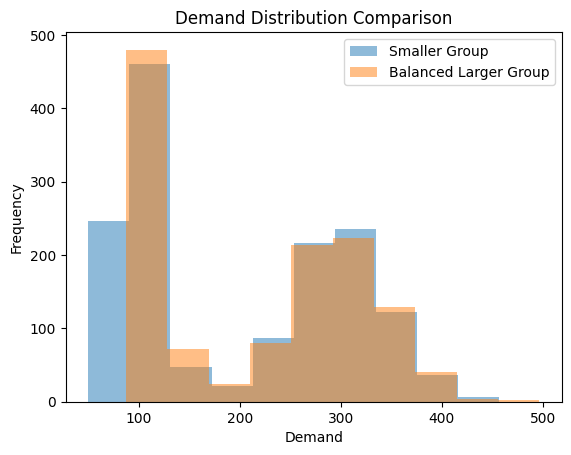

In [ ]:
import matplotlib.pyplot as plt

plt.hist(smaller_group['demand'], alpha=0.5, label='Smaller Group')
plt.hist(balanced_larger_group['demand'], alpha=0.5, label='Balanced Larger Group')
plt.xlabel('Demand')
plt.ylabel('Frequency')
plt.legend(loc='best')
plt.title('Demand Distribution Comparison')
plt.show()

#### Stratification V6

* This function first prepares the data by excluding NaN values and calculating strata based on the specified metric (demand).
* It then calculates the proportion of samples within each stratum for both the test and control groups.
* By comparing these proportions, the function identifies strata where the difference exceeds a defined tolerance (e.g., 1%).
* Strata with differences beyond this tolerance are considered imbalanced.
* The function prints out details of any imbalanced strata, based on the proportion of samples they contain within each group.


##### Skip this step if you are working with real data

**Create a random dataset**

Assign *mostly* balanced strata across test and control groups, with a couple non-balanced that differ between 2% and 8%.

In [ ]:
import numpy as np
import pandas as pd

# 1: Create a fake dataset
def create_fake_dataset(num_records=1000, seed=44):
    np.random.seed(seed)

    # Generate upm_id as a unique identifier for each record
    upm_id = np.arange(1, num_records + 1)

    # Generate a right-skewed, bimodal distribution for demand
    mode1 = np.random.lognormal(mean=np.log(150), sigma=0.3, size=int(num_records * 0.52))
    mode2 = np.random.lognormal(mean=np.log(157), sigma=0.5, size=int(num_records * 0.48))
    demand = np.concatenate([mode1, mode2])
    np.random.shuffle(demand)  # Shuffle to mix the modes well

    # Ensure all demand values are positive (log-normal already produces positive values)
    demand = np.abs(demand)

    # Generate a binary buyer column, where about 20% are buyers
    buyer = np.random.choice([0, 1], size=num_records, p=[0.8, 0.2])

    # Create DataFrame with upm_id, demand, and buyer columns
    df_aa = pd.DataFrame({
        'upm_id': upm_id,
        'demand': demand,
        'buyer': buyer
    })

    # Set demand to 0 for non-buyers
    df_aa.loc[df_aa['buyer'] == 0, 'demand'] = 0

    # Initialize 'test_control' column (all control by default)
    df_aa['test_control'] = 'control'

    return df_aa

# 2: Assign strata using np.percentile and np.digitize
def assign_strata(df_aa, metric='demand', num_strata=8):
    """
    This function calculates percentile boundaries and assigns strata based on the specified metric (e.g., 'demand').
    It assigns the data into the specified number of strata without enforcing equal-sized groups.
    """
    # Split the data into buyers and non-buyers
    buyers = df_aa[df_aa['buyer'] == 1].copy()
    non_buyers = df_aa[df_aa['buyer'] == 0].copy()

    # Calculate percentile boundaries to evenly split the buyers into num_strata parts
    percentile_values = np.linspace(0, 100, num=num_strata + 1)[1:-1]
    percentiles_combined = np.percentile(buyers[metric], percentile_values)

    # Assign strata based on calculated percentiles
    buyers['stratum'] = np.digitize(buyers[metric], percentiles_combined)

    # Assign a single stratum (e.g., 8) for non-buyers
    non_buyers['stratum'] = num_strata

    # Concatenate the buyers and non-buyers back into a single dataframe
    df_aa = pd.concat([buyers, non_buyers])

    return df_aa

# 3: Create artificial imbalance in the fake dataset
def create_imbalance(df_aa, min_imbalance=0.02, max_imbalance=0.08):
    # Randomly select 1 to 3 strata for imbalancing
    num_imbalanced_strata = np.random.randint(1, 4)  # Select 1 to 3 strata
    imbalanced_strata = np.random.choice(df_aa['stratum'].unique(), num_imbalanced_strata, replace=False)

    # Loop through each stratum and assign 50% to 'test' for balanced strata and imbalance selected strata
    for stratum in df_aa['stratum'].unique():
        stratum_indices = df_aa[df_aa['stratum'] == stratum].index

        if stratum in imbalanced_strata:
            # Introduce a smaller imbalance (e.g., 48% test and 52% control, or vice versa)
            imbalance_shift = np.random.uniform(min_imbalance, max_imbalance)  # Shift between min_imbalance and max_imbalance
            if np.random.rand() < 0.5:
                test_frac = 0.5 + imbalance_shift  # More test
            else:
                test_frac = 0.5 - imbalance_shift  # More control
        else:
            # Balanced 50-50
            test_frac = 0.5

        # Assign 'test' to the selected fraction
        test_indices = np.random.choice(stratum_indices, size=int(test_frac * len(stratum_indices)), replace=False)
        df_aa.loc[test_indices, 'test_control'] = 'test'

    return df_aa

# Combine the functions to generate the final dataset
df_aa = create_fake_dataset(num_records=1000)
df_aa = assign_strata(df_aa)
df_aa = create_imbalance(df_aa)

# Display the first few rows and description of the final dataset
print(df_aa.head())
print(df_aa.describe())


    upm_id      demand  buyer test_control  stratum
3        4  262.847448      1      control        7
5        6  170.066339      1      control        4
7        8  131.365052      1      control        2
12      13  176.543909      1         test        5
33      34  229.953171      1         test        6
            upm_id       demand        buyer      stratum
count  1000.000000  1000.000000  1000.000000  1000.000000
mean    500.500000    31.902720     0.188000     7.154000
std     288.819436    75.634779     0.390908     2.022467
min       1.000000     0.000000     0.000000     0.000000
25%     250.750000     0.000000     0.000000     8.000000
50%     500.500000     0.000000     0.000000     8.000000
75%     750.250000     0.000000     0.000000     8.000000
max    1000.000000   672.846860     1.000000     8.000000


##### Assign Strata

In [ ]:
import numpy as np
import pandas as pd

# Function to assign strata based on 'demand'
# All non-buyers assigned to stratum 8

def assign_strata(df_aa, metric='demand', num_strata=8):
    """
    This function calculates percentile boundaries and assigns strata based on the 'demand' metric.
    Non-buyers are assigned to stratum 8.

    Parameters:
    - df_aa: The input DataFrame.
    - metric: The column representing the metric to assign strata.
    - num_strata: The number of strata to create.

    Returns:
    - df_aa: The DataFrame with an added 'stratum' column.
    """

    # Exclude rows where the metric is NaN
    df_aa_clean = df_aa.dropna(subset=[metric])

    # Split the data into buyers and non-buyers
    buyers = df_aa_clean[df_aa_clean['buyer'] == 1].copy()
    non_buyers = df_aa_clean[df_aa_clean['buyer'] == 0].copy()

    # Calculate percentile boundaries to evenly split the buyers into num_strata parts
    percentile_values = np.linspace(0, 100, num=num_strata + 1)[1:-1]
    percentiles_combined = np.percentile(buyers[metric], percentile_values)

    # Assign strata based on calculated percentiles for buyers
    buyers['stratum'] = np.digitize(buyers[metric], percentiles_combined)

    # Assign stratum 8 for all non-buyers
    non_buyers['stratum'] = num_strata

    # Concatenate the buyers and non-buyers back into a single DataFrame
    df_aa = pd.concat([buyers, non_buyers])

    return df_aa

# Example usage
df_aa = assign_strata(df_aa, metric='demand', num_strata=8)

# Display the first few rows of the dataset
print(df_aa.head())


    upm_id      demand  buyer test_control  stratum
3        4  262.847448      1      control        7
5        6  170.066339      1      control        4
7        8  131.365052      1      control        2
12      13  176.543909      1         test        5
33      34  229.953171      1         test        6


##### Check for Imbalance

In [ ]:
import pandas as pd
import numpy as np

def check_imbalance(df_test, df_control, tolerance):
    """
    This function calculates the proportions of each stratum for the test and control groups, compares them,
    and identifies any imbalances that exceed the specified tolerance.
    """
    test_stratum_proportion = df_test['stratum'].value_counts(normalize=True).sort_index()
    control_stratum_proportion = df_control['stratum'].value_counts(normalize=True).sort_index()

    print("\nTest Group Strata Proportions:\n", test_stratum_proportion)
    print("Control Group Strata Proportions:\n", control_stratum_proportion)

    imbalanced_strata = []

    for stratum in test_stratum_proportion.index:
        test_prop = test_stratum_proportion.get(stratum, 0)
        control_prop = control_stratum_proportion.get(stratum, 0)
        proportion_diff = abs(test_prop - control_prop)

        if proportion_diff > tolerance:
            imbalanced_strata.append({
                'stratum': stratum,
                'test_proportion': test_prop,
                'control_proportion': control_prop,
                'difference': proportion_diff
            })

    if imbalanced_strata:
        print("\nImbalanced strata found (difference exceeds tolerance of {}):".format(tolerance))
        for imbalance in imbalanced_strata:
            print(f"Stratum {imbalance['stratum']}: Test Proportion = {imbalance['test_proportion']:.4f}, Control Proportion = {imbalance['control_proportion']:.4f}, Difference = {imbalance['difference']:.4f}")
    else:
        print("\nNo imbalanced strata found (all differences within tolerance).")

    return imbalanced_strata


# Split df_aa into test and control groups
df_test = df_aa[df_aa['test_control'] == 'test']
df_control = df_aa[df_aa['test_control'] == 'control']

# Call the function with a specified tolerance, e.g., 0.01 (1%)
check_imbalance(df_test, df_control, tolerance=0.01)



Test Group Strata Proportions:
 stratum
0    0.027842
1    0.023202
2    0.027842
3    0.020882
4    0.025522
5    0.027842
6    0.025522
7    0.027842
8    0.793503
Name: proportion, dtype: float64
Control Group Strata Proportions:
 stratum
0    0.021090
1    0.022847
2    0.021090
3    0.024605
4    0.021090
5    0.021090
6    0.021090
7    0.021090
8    0.826011
Name: proportion, dtype: float64

Imbalanced strata found (difference exceeds tolerance of 0.01):
Stratum 8: Test Proportion = 0.7935, Control Proportion = 0.8260, Difference = 0.0325


[{'stratum': 8,
  'test_proportion': 0.7935034802784223,
  'control_proportion': 0.8260105448154658,
  'difference': 0.03250706453704344}]

##### Check imbalance 2

In [ ]:
import numpy as np
import pandas as pd

# Function to calculate proportions and check for imbalances
def check_imbalance(df_test, df_control, tolerance):
    """
    This function calculates the proportions of each stratum for the test and control groups, compares them,
    and identifies any imbalances that exceed the specified tolerance.
    """
    # Calculate proportions of each stratum for test and control groups
    test_stratum_proportion = df_test['stratum'].value_counts(normalize=True).sort_index()
    control_stratum_proportion = df_control['stratum'].value_counts(normalize=True).sort_index()

    print("\nTest Group Strata Proportions:\n", test_stratum_proportion)
    print("Control Group Strata Proportions:\n", control_stratum_proportion)

    imbalanced_strata = []
    for stratum in test_stratum_proportion.index:
        test_prop = test_stratum_proportion.get(stratum, 0)
        control_prop = control_stratum_proportion.get(stratum, 0)
        proportion_diff = abs(test_prop - control_prop)

        if proportion_diff > tolerance:
            imbalanced_strata.append({
                'stratum': stratum,
                'test_proportion': test_prop,
                'control_proportion': control_prop,
                'difference': proportion_diff
            })

    # Print imbalanced strata if found
    if imbalanced_strata:
        print("\nImbalanced strata found (difference exceeds tolerance of {}):".format(tolerance))
        for imbalance in imbalanced_strata:
            print(f"Stratum {imbalance['stratum']}: Test Proportion = {imbalance['test_proportion']:.4f}, Control Proportion = {imbalance['control_proportion']:.4f}, Difference = {imbalance['difference']:.4f}")
    else:
        print("\nNo imbalanced strata found (all differences within tolerance).")

    return imbalanced_strata

# Example usage
df_test = df_aa[df_aa['test_control'] == 'test']
df_control = df_aa[df_aa['test_control'] == 'control']

# Call the function with a specified tolerance
check_imbalance(df_test, df_control, tolerance=0.01)



Test Group Strata Proportions:
 stratum
0    0.027842
1    0.023202
2    0.027842
3    0.020882
4    0.025522
5    0.027842
6    0.025522
7    0.027842
8    0.793503
Name: proportion, dtype: float64
Control Group Strata Proportions:
 stratum
0    0.021090
1    0.022847
2    0.021090
3    0.024605
4    0.021090
5    0.021090
6    0.021090
7    0.021090
8    0.826011
Name: proportion, dtype: float64

Imbalanced strata found (difference exceeds tolerance of 0.01):
Stratum 8: Test Proportion = 0.7935, Control Proportion = 0.8260, Difference = 0.0325


[{'stratum': 8,
  'test_proportion': 0.7935034802784223,
  'control_proportion': 0.8260105448154658,
  'difference': 0.03250706453704344}]

##### Adjust Imbalance (rebalancing)

In [ ]:
# Function to assess and adjust stratification, balancing the groups
def rebalance(df_aa, metric='demand', num_strata=8, tolerance=0.01):
    """
    This function assesses which Demand strata have mismatched sample sizes between test and control groups,
    prints those strata, and then rebalances the groups by randomly omitting records to achieve balance.
    """
    df_aa_clean = df_aa.dropna(subset=[metric])  # Exclude rows where 'demand' (or other metric) is NaN

    # Separate test and control groups
    df_test = df_aa_clean[df_aa_clean['test_control'] == 'test'].copy()
    df_control = df_aa_clean[df_aa_clean['test_control'] == 'control'].copy()

    # Assign strata based on the specified metric
    df_test = assign_strata(df_test, metric=metric, num_strata=num_strata)
    df_control = assign_strata(df_control, metric=metric, num_strata=num_strata)

    # Identify imbalanced strata
    imbalanced_strata = check_imbalance(df_test, df_control, tolerance)

    # Adjust the dataset to balance strata by randomly omitting records in imbalanced strata
    for imbalance in imbalanced_strata:
        stratum = imbalance['stratum']
        test_count = df_test[df_test['stratum'] == stratum].shape[0]
        control_count = df_control[df_control['stratum'] == stratum].shape[0]

        # Calculate how many records to remove, but only for imbalanced strata
        if test_count > control_count:
            excess_records = test_count - control_count
            indices_to_remove = np.random.choice(df_test[df_test['stratum'] == stratum].index, size=excess_records, replace=False)
            df_test = df_test.drop(indices_to_remove)
        elif control_count > test_count:
            excess_records = control_count - test_count
            indices_to_remove = np.random.choice(df_control[df_control['stratum'] == stratum].index, size=excess_records, replace=False)
            df_control = df_control.drop(indices_to_remove)

    return df_test, df_control

# Display the first few rows and description of the adjusted datasets
'''
print(df_test_adjusted.head())
print(df_control_adjusted.head())
'''

# Example call with all functions
df_test_adjusted, df_control_adjusted = rebalance(df_aa, 'demand', num_strata=8, tolerance=0.01)


# Check for imbalance again
check_imbalance(df_test_adjusted, df_control_adjusted, tolerance=0.01)

[{'stratum': 8,
  'test_proportion': 0.7935034802784223,
  'control_proportion': 0.7755102040816326,
  'difference': 0.017993276196789698}]

##### Rebalance Attempt 2

In [ ]:
import numpy as np
import pandas as pd

# Function to calculate proportions and check for imbalances
def check_imbalance(df_test, df_control, tolerance):
    """
    This function calculates the proportions of each stratum for the test and control groups, compares them,
    and identifies any imbalances that exceed the specified tolerance.
    """
    test_stratum_proportion = df_test['stratum'].value_counts(normalize=True).sort_index()
    control_stratum_proportion = df_control['stratum'].value_counts(normalize=True).sort_index()

    imbalanced_strata = []
    for stratum in test_stratum_proportion.index:
        test_prop = test_stratum_proportion.get(stratum, 0)
        control_prop = control_stratum_proportion.get(stratum, 0)
        proportion_diff = abs(test_prop - control_prop)

        if proportion_diff > tolerance:
            imbalanced_strata.append({
                'stratum': stratum,
                'test_proportion': test_prop,
                'control_proportion': control_prop,
                'difference': proportion_diff
            })

    return imbalanced_strata

# Function to assess and adjust stratification, balancing the groups
import numpy as np
import pandas as pd

# Function to calculate proportions and check for imbalances
def check_imbalance(df_test, df_control, tolerance):
    """
    This function calculates the proportions of each stratum for the test and control groups, compares them,
    and identifies any imbalances that exceed the specified tolerance.
    """
    test_stratum_proportion = df_test['stratum'].value_counts(normalize=True).sort_index()
    control_stratum_proportion = df_control['stratum'].value_counts(normalize=True).sort_index()

    print("\nTest Group Strata Proportions:\n", test_stratum_proportion)
    print("Control Group Strata Proportions:\n", control_stratum_proportion)

    imbalanced_strata = []
    for stratum in test_stratum_proportion.index:
        test_prop = test_stratum_proportion.get(stratum, 0)
        control_prop = control_stratum_proportion.get(stratum, 0)
        proportion_diff = abs(test_prop - control_prop)

        if proportion_diff > tolerance:
            imbalanced_strata.append({
                'stratum': stratum,
                'test_proportion': test_prop,
                'control_proportion': control_prop,
                'difference': proportion_diff
            })

    if imbalanced_strata:
        print("\nImbalanced strata found (difference exceeds tolerance of {}):".format(tolerance))
        for imbalance in imbalanced_strata:
            print(f"Stratum {imbalance['stratum']}: Test Proportion = {imbalance['test_proportion']:.4f}, Control Proportion = {imbalance['control_proportion']:.4f}, Difference = {imbalance['difference']:.4f}")
    else:
        print("\nNo imbalanced strata found (all differences within tolerance).")

    return imbalanced_strata

# Function to assess and adjust stratification, balancing the groups
def rebalance(df_aa, metric='demand', num_strata=8, tolerance=0.01, max_iterations=10):
    """
    This function assesses which Demand strata have mismatched sample sizes between test and control groups,
    and iteratively rebalances the groups by randomly omitting records until all imbalances are within the specified tolerance.
    """
    df_aa_clean = df_aa.dropna(subset=[metric])  # Exclude rows where 'demand' (or other metric) is NaN

    # Separate test and control groups
    df_test = df_aa_clean[df_aa_clean['test_control'] == 'test'].copy()
    df_control = df_aa_clean[df_aa_clean['test_control'] == 'control'].copy()

    # Assign strata based on the specified metric
    df_test = assign_strata(df_test, metric=metric, num_strata=num_strata)
    df_control = assign_strata(df_control, metric=metric, num_strata=num_strata)

    iteration_count = 0

    # Iteratively rebalance until no imbalanced strata remain or max iterations is reached
    while True:
        iteration_count += 1
        imbalanced_strata = check_imbalance(df_test, df_control, tolerance)

        if not imbalanced_strata or iteration_count >= max_iterations:
            # If no imbalanced strata are found or max iterations are reached, exit the loop
            if iteration_count >= max_iterations:
                print(f"Reached maximum iterations ({max_iterations}). Exiting...")
            break

        # Only adjust the specific strata that are identified as imbalanced
        for imbalance in imbalanced_strata:
            stratum = imbalance['stratum']
            test_count = df_test[df_test['stratum'] == stratum].shape[0]
            control_count = df_control[df_control['stratum'] == stratum].shape[0]

            # Apply the same proportional removal method for imbalanced strata
            if test_count > control_count:
                excess_records = int(imbalance['difference'] * test_count)
                indices_to_remove = np.random.choice(df_test[df_test['stratum'] == stratum].index, size=excess_records, replace=False)
                df_test = df_test.drop(indices_to_remove)
            elif control_count > test_count:
                excess_records = int(imbalance['difference'] * control_count)
                indices_to_remove = np.random.choice(df_control[df_control['stratum'] == stratum].index, size=excess_records, replace=False)
                df_control = df_control.drop(indices_to_remove)

        print(f"Iteration {iteration_count}: Adjusted imbalanced strata: {imbalanced_strata}")

    return df_test, df_control

# Example call with all functions
df_test_adjusted, df_control_adjusted = rebalance(df_aa, 'demand', num_strata=8, tolerance=0.01, max_iterations=10)

# Check for imbalance again
check_imbalance(df_test_adjusted, df_control_adjusted, tolerance=0.01)



Test Group Strata Proportions:
 stratum
0    0.025522
1    0.025522
2    0.025522
3    0.025522
4    0.025522
5    0.025522
6    0.025522
7    0.027842
8    0.793503
Name: proportion, dtype: float64
Control Group Strata Proportions:
 stratum
0    0.022847
1    0.021090
2    0.021090
3    0.021090
4    0.022847
5    0.021090
6    0.021090
7    0.022847
8    0.826011
Name: proportion, dtype: float64

Imbalanced strata found (difference exceeds tolerance of 0.01):
Stratum 8: Test Proportion = 0.7935, Control Proportion = 0.8260, Difference = 0.0325
Iteration 1: Adjusted imbalanced strata: [{'stratum': 8, 'test_proportion': 0.7935034802784223, 'control_proportion': 0.8260105448154658, 'difference': 0.03250706453704344}]

Test Group Strata Proportions:
 stratum
0    0.025522
1    0.025522
2    0.025522
3    0.025522
4    0.025522
5    0.025522
6    0.025522
7    0.027842
8    0.793503
Name: proportion, dtype: float64
Control Group Strata Proportions:
 stratum
0    0.023466
1    0.021661
2 

[]

##### Rebalancing Attempt 3 - Verbose

In [ ]:
import numpy as np
import pandas as pd

# Function to calculate proportions and check for imbalances within each stratum
def check_imbalance(df_test, df_control, tolerance):
    """
    This function calculates the proportions of test and control records within each stratum
    and identifies any imbalances that exceed the specified tolerance.
    """
    imbalanced_strata = []
    strata = sorted(df_test['stratum'].unique())  # List of all strata

    for stratum in strata:
        test_count = df_test[df_test['stratum'] == stratum].shape[0]
        control_count = df_control[df_control['stratum'] == stratum].shape[0]

        # Calculate proportion difference relative to the total count in that stratum
        total_count = test_count + control_count
        if total_count == 0:
            continue  # Skip if no records in this stratum

        test_proportion = test_count / total_count
        control_proportion = control_count / total_count
        proportion_diff = abs(test_proportion - control_proportion)

        if proportion_diff > tolerance:
            imbalanced_strata.append({
                'stratum': stratum,
                'test_count': test_count,
                'control_count': control_count,
                'difference': proportion_diff
            })

    return imbalanced_strata

# Rebalance function (adjust within each stratum)
def rebalance(df_aa, metric='demand', num_strata=8, tolerance=0.01, max_iterations=1):
    """
    This function assesses which strata have imbalanced test and control group sizes
    and directly adjusts the groups to ensure they are balanced within the specified tolerance.
    """
    df_aa_clean = df_aa.dropna(subset=[metric])  # Exclude rows where 'demand' (or other metric) is NaN

    # Separate test and control groups
    df_test = df_aa_clean[df_aa_clean['test_control'] == 'test'].copy()
    df_control = df_aa_clean[df_aa_clean['test_control'] == 'control'].copy()

    # Assign strata based on the specified metric
    df_test = assign_strata(df_test, metric=metric, num_strata=num_strata)
    df_control = assign_strata(df_control, metric=metric, num_strata=num_strata)

    iteration_count = 0

    # Iteratively rebalance until no imbalanced strata remain or max iterations is reached
    while iteration_count < max_iterations:
        iteration_count += 1
        print(f"\n--- Iteration {iteration_count} ---")

        # Identify imbalanced strata
        imbalanced_strata = check_imbalance(df_test, df_control, tolerance)

        # If no imbalanced strata are found, break
        if not imbalanced_strata:
            print("No imbalanced strata found. Rebalancing complete.")
            break

        print(f"Imbalanced strata: {imbalanced_strata}")

        # Rebalance each imbalanced stratum
        for imbalance in imbalanced_strata:
            stratum = imbalance['stratum']
            test_count = imbalance['test_count']
            control_count = imbalance['control_count']

            print(f"\nStratum {stratum} - Test Count: {test_count}, Control Count: {control_count}")

            # Determine which group has more records and remove excess
            if test_count > control_count:
                records_to_remove = test_count - control_count
                print(f"Removing {records_to_remove} records from test group in Stratum {stratum}")
                indices_to_remove = np.random.choice(df_test[df_test['stratum'] == stratum].index, size=records_to_remove, replace=False)
                df_test = df_test.drop(indices_to_remove)
            elif control_count > test_count:
                records_to_remove = control_count - test_count
                print(f"Removing {records_to_remove} records from control group in Stratum {stratum}")
                indices_to_remove = np.random.choice(df_control[df_control['stratum'] == stratum].index, size=records_to_remove, replace=False)
                df_control = df_control.drop(indices_to_remove)

        # Print the result of the iteration
        print(f"Iteration {iteration_count}: Adjusted imbalanced strata: {imbalanced_strata}")

    return df_test, df_control

# Example call with all functions
df_test_adjusted, df_control_adjusted = rebalance(df_aa, 'demand', num_strata=8, tolerance=0.01, max_iterations=10)

# Check for imbalance again
imbalanced_strata = check_imbalance(df_test_adjusted, df_control_adjusted, tolerance=0.01)
if not imbalanced_strata:
    print("No imbalanced strata found (all differences within tolerance).")
else:
    print(f"Imbalanced strata after adjustment: {imbalanced_strata}")



--- Iteration 1 ---
Imbalanced strata: [{'stratum': 0, 'test_count': 11, 'control_count': 13, 'difference': 0.08333333333333331}, {'stratum': 1, 'test_count': 11, 'control_count': 12, 'difference': 0.04347826086956519}, {'stratum': 2, 'test_count': 11, 'control_count': 12, 'difference': 0.04347826086956519}, {'stratum': 3, 'test_count': 11, 'control_count': 12, 'difference': 0.04347826086956519}, {'stratum': 4, 'test_count': 11, 'control_count': 13, 'difference': 0.08333333333333331}, {'stratum': 5, 'test_count': 11, 'control_count': 12, 'difference': 0.04347826086956519}, {'stratum': 6, 'test_count': 11, 'control_count': 12, 'difference': 0.04347826086956519}, {'stratum': 7, 'test_count': 12, 'control_count': 13, 'difference': 0.040000000000000036}, {'stratum': 8, 'test_count': 342, 'control_count': 470, 'difference': 0.1576354679802956}]

Stratum 0 - Test Count: 11, Control Count: 13
Removing 2 records from control group in Stratum 0

Stratum 1 - Test Count: 11, Control Count: 12
Re

##### Rebalancing Attempt 4 - consise Attempt 3



In [ ]:
import numpy as np
import pandas as pd

# Function to calculate proportions and check for imbalances within each stratum
def check_imbalance(df_test, df_control, tolerance):
    """
    This function calculates the proportions of test and control records within each stratum
    and identifies any imbalances that exceed the specified tolerance.
    """
    imbalanced_strata = []
    strata = sorted(df_test['stratum'].unique())  # List of all strata

    for stratum in strata:
        test_count = df_test[df_test['stratum'] == stratum].shape[0]
        control_count = df_control[df_control['stratum'] == stratum].shape[0]

        # Calculate proportion difference relative to the total count in that stratum
        total_count = test_count + control_count
        if total_count == 0:
            continue  # Skip if no records in this stratum

        test_proportion = test_count / total_count
        control_proportion = control_count / total_count
        proportion_diff = abs(test_proportion - control_proportion)

        if proportion_diff > tolerance:
            imbalanced_strata.append({
                'stratum': stratum,
                'test_count': test_count,
                'control_count': control_count,
                'difference': proportion_diff
            })

    return imbalanced_strata

# Rebalance function (adjust within each stratum)
def rebalance(df_aa, metric='demand', num_strata=8, tolerance=0.01, max_iterations=10):
    """
    This function assesses which strata have imbalanced test and control group sizes
    and directly adjusts the groups to ensure they are balanced within the specified tolerance.
    Returns a single balanced dataframe.
    """
    df_aa_clean = df_aa.dropna(subset=[metric])  # Exclude rows where 'demand' (or other metric) is NaN

    # Separate test and control groups
    df_test = df_aa_clean[df_aa_clean['test_control'] == 'test'].copy()
    df_control = df_aa_clean[df_aa_clean['test_control'] == 'control'].copy()

    # Assign strata based on the specified metric
    df_test = assign_strata(df_test, metric=metric, num_strata=num_strata)
    df_control = assign_strata(df_control, metric=metric, num_strata=num_strata)

    iteration_count = 0

    # Iteratively rebalance until no imbalanced strata remain or max iterations is reached
    while iteration_count < max_iterations:
        iteration_count += 1

        # Identify imbalanced strata
        imbalanced_strata = check_imbalance(df_test, df_control, tolerance)

        # If no imbalanced strata are found, break the loop
        if not imbalanced_strata:
            print(f"No imbalanced strata found after {iteration_count} iteration(s). Rebalancing complete.")
            break

        # Rebalance each imbalanced stratum
        for imbalance in imbalanced_strata:
            stratum = imbalance['stratum']
            test_count = imbalance['test_count']
            control_count = imbalance['control_count']

            # Determine which group has more records and remove excess
            if test_count > control_count:
                records_to_remove = test_count - control_count
                indices_to_remove = np.random.choice(df_test[df_test['stratum'] == stratum].index, size=records_to_remove, replace=False)
                df_test = df_test.drop(indices_to_remove)
                print(f"Iteration {iteration_count}: Removed {records_to_remove} records from test group in stratum {stratum}")
            elif control_count > test_count:
                records_to_remove = control_count - test_count
                indices_to_remove = np.random.choice(df_control[df_control['stratum'] == stratum].index, size=records_to_remove, replace=False)
                df_control = df_control.drop(indices_to_remove)
                print(f"Iteration {iteration_count}: Removed {records_to_remove} records from control group in stratum {stratum}")

    # Concatenate the balanced test and control groups back into a single dataframe
    df_aa_balanced = pd.concat([df_test, df_control]).sort_values(by='upm_id').reset_index(drop=True)

    return df_aa_balanced

# Example call to the function
df_aa_balanced = rebalance(df_aa, 'demand', num_strata=8, tolerance=0.01, max_iterations=10)

# Check for imbalance again
imbalanced_strata = check_imbalance(df_aa_balanced[df_aa_balanced['test_control'] == 'test'],
                                    df_aa_balanced[df_aa_balanced['test_control'] == 'control'],
                                    tolerance=0.01)
if not imbalanced_strata:
    print("No imbalanced strata found. The dataset is balanced.")
    print(df_aa_balanced.head())
else:
    print(f"Imbalanced strata after adjustment: {imbalanced_strata}")


Iteration 1: Removed 2 records from control group in stratum 0
Iteration 1: Removed 1 records from control group in stratum 1
Iteration 1: Removed 1 records from control group in stratum 2
Iteration 1: Removed 1 records from control group in stratum 3
Iteration 1: Removed 2 records from control group in stratum 4
Iteration 1: Removed 1 records from control group in stratum 5
Iteration 1: Removed 1 records from control group in stratum 6
Iteration 1: Removed 1 records from control group in stratum 7
Iteration 1: Removed 128 records from control group in stratum 8
No imbalanced strata found after 2 iteration(s). Rebalancing complete.
No imbalanced strata found. The dataset is balanced.
   upm_id      demand  buyer test_control  stratum
0       3    0.000000      0         test        8
1       4  262.847448      1      control        7
2       6  170.066339      1      control        4
3       7    0.000000      0      control        8
4       8  131.365052      1      control        2


In [ ]:
print(df_test_adjusted.head())
print(df_control_adjusted.head())

    upm_id      demand  buyer test_control  stratum
12      13  176.543909      1         test        5
33      34  229.953171      1         test        6
37      38   45.082693      1         test        0
52      53  191.733595      1         test        5
62      63  211.609794      1         test        6
    upm_id      demand  buyer test_control  stratum
3        4  262.847448      1      control        7
5        6  170.066339      1      control        4
7        8  131.365052      1      control        2
40      41  150.337339      1      control        4
57      58  195.260186      1      control        5


### Percent Rank (current method)

This code continues with usage of the percent rank function, but implemented in a randomized way to reduce bias.

#### Assigning by Perc Rank (OG Method)

In [ ]:
#%python
def bucket_and_rank(df, metric='demand', num_buckets=8):
    """
    Assigns demand buckets based on percentiles and then assigns a random rank within each bucket.

    Args:
    df (pd.DataFrame): The input DataFrame.
    metric (str): The column name for the metric to bucket by.
    num_buckets (int): The number of buckets to divide the data into.

    Returns:
    pd.DataFrame: The modified DataFrame with demand buckets and random ranks.
    """
    # Calculate demand buckets based on percentiles
    percentiles = np.percentile(df[metric], np.linspace(0, 100, num_buckets + 1)[1:-1])
    df['demand_bucket'] = np.digitize(df[metric], percentiles)

    # Assign a random rank within each demand bucket
    def assign_random_rank(sub_df):
        sub_df['random_rank'] = np.random.rand(len(sub_df))
        sub_df['random_rank'] = sub_df['random_rank'].rank(method='first') / len(sub_df)
        return sub_df

    # Apply the function to each group
    df = df.groupby('demand_bucket', group_keys=False).apply(assign_random_rank)
    return df

# Apply the function to your DataFrame
df_aa_ranked = bucket_and_rank(df_aa, 'demand', num_buckets=8)

# Display the first few rows to verify the output
df_aa_ranked.head()

,upm_id,demand,buyer,test_control,demand_bucket,random_rank
0,1,243.514657,1,control,3,0.728
1,2,330.708335,0,control,6,0.096
2,3,66.428424,0,control,0,0.288
3,4,75.758046,1,test,1,0.480
4,5,82.384666,0,test,2,0.576


#### Identifying Imbalance by Perc Rank (OG Method)

In [ ]:
# %python
import pandas as pd
import numpy as np

def assess_balance_using_precomputed_buckets(df, tolerance=0.01):
    df_test = df_aa_ranked[df_aa_ranked['test_control'] == 'test'].copy()
    df_control = df_aa_ranked[df_aa_ranked['test_control'] == 'control'].copy()

    mismatches = []
    for bucket in sorted(df_aa_ranked['demand_bucket'].unique()):
        if bucket in df_test['demand_bucket'].values and bucket in df_control['demand_bucket'].values:
            avg_rank_test = df_test[df_test['demand_bucket'] == bucket]['random_rank'].mean()
            avg_rank_control = df_control[df_control['demand_bucket'] == bucket]['random_rank'].mean()

            if abs(avg_rank_test - avg_rank_control) > tolerance:
                mismatches.append(bucket)
                print(f"Demand bucket {bucket} is imbalanced. Test group average rank: {avg_rank_test:.2%}, Control group average rank: {avg_rank_control:.2%}.")

    if not mismatches:
        print("All demand buckets are balanced across test and control groups within the defined tolerance.")

    return mismatches

# First, apply the bucket_and_rank function to df_aa
df_aa_processed = bucket_and_rank(df_aa, 'demand', num_buckets=8)

# Then, assess balance using the processed DataFrame
mismatches = assess_balance_using_precomputed_buckets(df_aa_processed, tolerance=0.01)
print("Identified mismatches in demand buckets:", mismatches)



Demand bucket 1 is imbalanced. Test group average rank: 51.05%, Control group average rank: 49.90%.
Demand bucket 2 is imbalanced. Test group average rank: 47.59%, Control group average rank: 52.09%.
Demand bucket 3 is imbalanced. Test group average rank: 53.19%, Control group average rank: 48.72%.
Demand bucket 4 is imbalanced. Test group average rank: 51.58%, Control group average rank: 49.59%.
Demand bucket 5 is imbalanced. Test group average rank: 56.07%, Control group average rank: 47.42%.
Demand bucket 6 is imbalanced. Test group average rank: 53.13%, Control group average rank: 48.52%.
Demand bucket 7 is imbalanced. Test group average rank: 53.71%, Control group average rank: 48.54%.
Identified mismatches in demand buckets: [1, 2, 3, 4, 5, 6, 7]


#### Balancing by Perc Rank (OG Method)

In [ ]:
# Splitting df_aa_processed into test and control groups
df_test = df_aa_processed[df_aa_processed['test_control'] == 'test']
df_control = df_aa_processed[df_aa_processed['test_control'] == 'control']

# Rebalancing the dataset based on identified mismatches
balanced_df = rebalance_strata_based_on_mismatches(df_test, df_control, mismatches)

# Optionally, inspect the balanced DataFrame
print(balanced_df.head())


     upm_id     demand  buyer test_control  demand_bucket  random_rank
52       53  61.223306      1         test              0        0.112
59       60  59.493366      0         test              0        0.704
109     110  66.532063      0         test              0        0.712
123     124  60.214780      0         test              0        0.528
128     129  65.184913      1         test              0        0.024


#### Check post Perc Rank balancing

In [ ]:
def check_balance_post_rebalancing(balanced_df, tolerance=0.01):
    """
    Checks the balance of a DataFrame after rebalancing efforts have been made. It assesses
    balance by comparing the test and control groups within each demand bucket.

    Parameters:
    - balanced_df: DataFrame containing the test and control group data after rebalancing.
    - tolerance: The tolerance for differences in average percent ranks.

    Returns:
    - Prints out the results of the balance check, indicating whether the dataset is balanced.
    """
    # Assuming 'balanced_df' retains 'demand_bucket' and 'random_rank' from previous processing

    # Separate the balanced DataFrame back into test and control groups
    df_test_balanced = balanced_df[balanced_df['test_control'] == 'test']
    df_control_balanced = balanced_df[balanced_df['test_control'] == 'control']

    # Initialize list for tracking mismatches post-rebalancing
    new_mismatches = []

    # Iterate through each demand bucket to assess balance
    for bucket in sorted(balanced_df['demand_bucket'].unique()):
        # Check if both test and control groups have entries in this bucket
        if bucket in df_test_balanced['demand_bucket'].values and bucket in df_control_balanced['demand_bucket'].values:
            # Compute average random rank for each bucket in test and control
            avg_rank_test = df_test_balanced[df_test_balanced['demand_bucket'] == bucket]['random_rank'].mean()
            avg_rank_control = df_control_balanced[df_control_balanced['demand_bucket'] == bucket]['random_rank'].mean()

            # Identify mismatches based on the tolerance for difference in average ranks
            if abs(avg_rank_test - avg_rank_control) > tolerance:
                new_mismatches.append(bucket)
                print(f"Demand bucket {bucket} is imbalanced post-rebalancing. Test group average rank: {avg_rank_test:.2%}, Control group average rank: {avg_rank_control:.2%}.")

    # Message if all buckets are balanced within tolerance post-rebalancing
    if not new_mismatches:
        print("The dataset is now balanced across test and control groups within the defined tolerance.")
    else:
        print("Some imbalances still exist after rebalancing. Identified mismatches in demand buckets:", new_mismatches)

# Example usage with your balanced DataFrame
check_balance_post_rebalancing(balanced_df, tolerance=0.02)


Demand bucket 0 is imbalanced post-rebalancing. Test group average rank: 48.23%, Control group average rank: 51.50%.
Demand bucket 2 is imbalanced post-rebalancing. Test group average rank: 51.17%, Control group average rank: 48.36%.
Demand bucket 3 is imbalanced post-rebalancing. Test group average rank: 48.78%, Control group average rank: 52.34%.
Demand bucket 5 is imbalanced post-rebalancing. Test group average rank: 47.80%, Control group average rank: 51.26%.
Demand bucket 6 is imbalanced post-rebalancing. Test group average rank: 45.87%, Control group average rank: 55.36%.
Demand bucket 7 is imbalanced post-rebalancing. Test group average rank: 48.44%, Control group average rank: 54.01%.
Some imbalances still exist after rebalancing. Identified mismatches in demand buckets: [0, 2, 3, 5, 6, 7]


In [ ]:
def check_balance_post_rebalancing(balanced_df, tolerance=0.01):
    """
    Checks the balance of a DataFrame after rebalancing efforts have been made. It assesses
    balance by comparing the test and control groups within each demand bucket.

    Parameters:
    - balanced_df: DataFrame containing the test and control group data after rebalancing.
    - tolerance: The tolerance for differences in average percent ranks.

    Returns:
    - Prints out the results of the balance check, indicating whether the dataset is balanced.
    """
    # Separate the balanced DataFrame back into test and control groups
    df_test_balanced = balanced_df[balanced_df['test_control'] == 'test']
    df_control_balanced = balanced_df[balanced_df['test_control'] == 'control']

    # Initialize list for tracking mismatches post-rebalancing
    new_mismatches = []

    print("Reassessing balance after adjustments...")

    # Iterate through each demand bucket to assess balance
    for bucket in sorted(balanced_df['demand_bucket'].unique()):
        # Check if both test and control groups have entries in this bucket
        if bucket in df_test_balanced['demand_bucket'].values and bucket in df_control_balanced['demand_bucket'].values:
            # Compute average random rank for each bucket in test and control
            avg_rank_test = df_test_balanced[df_test_balanced['demand_bucket'] == bucket]['random_rank'].mean()
            avg_rank_control = df_control_balanced[df_control_balanced['demand_bucket'] == bucket]['random_rank'].mean()

            # Calculate the difference as a percentage
            diff_percentage = (avg_rank_test - avg_rank_control) * 100  # Convert to percentage

            # Always print the balance assessment for visibility
            print(f"Bucket {bucket}: Test Avg Rank: {avg_rank_test:.2%}, Control Avg Rank: {avg_rank_control:.2%}, Difference: {diff_percentage:.2f}%.")

            # Identify mismatches based on the tolerance for difference in average ranks
            if abs(avg_rank_test - avg_rank_control) > tolerance:
                new_mismatches.append(bucket)

    # Summary message post assessment
    if not new_mismatches:
        print("\nAll demand buckets are balanced across test and control groups within the defined tolerance.")
    else:
        print("\nSome imbalances still exist after rebalancing. Identified mismatches in demand buckets:", new_mismatches)


check_balance_post_rebalancing(balanced_df, tolerance=0.02)

Reassessing balance after adjustments...
Bucket 0: Test Avg Rank: 48.23%, Control Avg Rank: 51.50%, Difference: -3.27%.
Bucket 1: Test Avg Rank: 48.59%, Control Avg Rank: 49.29%, Difference: -0.70%.
Bucket 2: Test Avg Rank: 51.17%, Control Avg Rank: 48.36%, Difference: 2.81%.
Bucket 3: Test Avg Rank: 48.78%, Control Avg Rank: 52.34%, Difference: -3.56%.
Bucket 4: Test Avg Rank: 48.52%, Control Avg Rank: 49.87%, Difference: -1.35%.
Bucket 5: Test Avg Rank: 47.80%, Control Avg Rank: 51.26%, Difference: -3.46%.
Bucket 6: Test Avg Rank: 45.87%, Control Avg Rank: 55.36%, Difference: -9.49%.
Bucket 7: Test Avg Rank: 48.44%, Control Avg Rank: 54.01%, Difference: -5.56%.

Some imbalances still exist after rebalancing. Identified mismatches in demand buckets: [0, 2, 3, 5, 6, 7]


In [ ]:
import pandas as pd
import numpy as np

# Step 1: Bucket and Rank
def bucket_and_rank(df, metric='demand', num_buckets=8):
    print("Starting bucketing and ranking...")
    percentiles = np.percentile(df[metric], np.linspace(0, 100, num_buckets + 1)[1:-1])
    df['demand_bucket'] = np.digitize(df[metric], percentiles)

    def assign_random_rank(sub_df):
        sub_df['random_rank'] = np.random.rand(len(sub_df))
        sub_df['random_rank'] = sub_df['random_rank'].rank(method='first') / len(sub_df)
        return sub_df

    df = df.groupby('demand_bucket', group_keys=False).apply(assign_random_rank)
    print("Bucketing and ranking complete.\n")
    return df

# Step 2: Assess Initial Balance
def assess_balance_using_precomputed_buckets(df, tolerance=0.01):
    print("Assessing initial balance using precomputed buckets...")
    mismatches = []
    for bucket in sorted(df['demand_bucket'].unique()):
        df_test = df[(df['test_control'] == 'test') & (df['demand_bucket'] == bucket)]
        df_control = df[(df['test_control'] == 'control') & (df['demand_bucket'] == bucket)]
        avg_rank_test = df_test['random_rank'].mean() if not df_test.empty else 0
        avg_rank_control = df_control['random_rank'].mean() if not df_control.empty else 0

        diff_percentage = (avg_rank_test - avg_rank_control) * 100  # Convert to percentage

        if abs(avg_rank_test - avg_rank_control) > tolerance:
            mismatches.append(bucket)
            print(f"Bucket {bucket} is imbalanced. Test Avg Rank: {avg_rank_test:.2%}, Control Avg Rank: {avg_rank_control:.2%}, Difference: {diff_percentage:.2f}%.")
        else:
            print(f"Bucket {bucket} is balanced. Test Avg Rank: {avg_rank_test:.2%}, Control Avg Rank: {avg_rank_control:.2%}, Difference: {diff_percentage:.2f}%.")

    if not mismatches:
        print("All demand buckets are balanced within the defined tolerance.")
    else:
        print("Imbalances found in buckets:", mismatches)
    print("\n")
    return mismatches

# Step 3: Calculate Initial Proportions (No Changes Needed)
def calculate_initial_proportions(df):
    print("Calculating initial proportions...")
    counts = df.groupby(['demand_bucket', 'test_control']).size().unstack(fill_value=0)
    total = counts.sum(axis=1)
    counts['test_prop'] = counts['test'] / total
    counts['control_prop'] = counts['control'] / total
    counts['imbalance'] = abs(counts['test_prop'] - counts['control_prop'])
    print("Initial proportions calculated.\n")
    return counts


# Step 5: Calculate Weights for Balance
def calculate_weights_for_balance(df, tolerance=0.02):
    print("Calculating weights for each sample to achieve balance...")
    proportions = calculate_initial_proportions(df)

    # Initialize weights to 1 as default
    df['weight'] = 1.0

    for bucket, row in proportions.iterrows():
        imbalance = row['test_prop'] - row['control_prop']
        if abs(imbalance) > tolerance:
            # Adjust weights inversely proportional to imbalance magnitude
            weight_adjustment_test = 1 - (imbalance if imbalance > 0 else -imbalance) / 2
            weight_adjustment_control = 1 + (imbalance if imbalance > 0 else -imbalance) / 2

            df.loc[(df['demand_bucket'] == bucket) & (df['test_control'] == 'test'), 'weight'] = weight_adjustment_test
            df.loc[(df['demand_bucket'] == bucket) & (df['test_control'] == 'control'), 'weight'] = weight_adjustment_control

            print(f"Adjusted weights in bucket {bucket} due to imbalance of {imbalance*100:.2f}%.")

    print("Weight calculations complete.\n")
    return df

# Step 6: Re-assess Balance After Adjustments (Using the Same Function as Step 2)
def check_balance_post_rebalancing(balanced_df, tolerance=0.01):
    """
    Checks the balance of a DataFrame after rebalancing efforts have been made. It assesses
    balance by comparing the test and control groups within each demand bucket.

    Parameters:
    - balanced_df: DataFrame containing the test and control group data after rebalancing.
    - tolerance: The tolerance for differences in average percent ranks.

    Returns:
    - Prints out the results of the balance check, indicating whether the dataset is balanced.
    """
    # Separate the balanced DataFrame back into test and control groups
    df_test_balanced = balanced_df[balanced_df['test_control'] == 'test']
    df_control_balanced = balanced_df[balanced_df['test_control'] == 'control']

    # Initialize list for tracking mismatches post-rebalancing
    new_mismatches = []

    print("Reassessing balance after adjustments...")

    # Iterate through each demand bucket to assess balance
    for bucket in sorted(balanced_df['demand_bucket'].unique()):
        # Check if both test and control groups have entries in this bucket
        if bucket in df_test_balanced['demand_bucket'].values and bucket in df_control_balanced['demand_bucket'].values:
            # Compute average random rank for each bucket in test and control
            avg_rank_test = df_test_balanced[df_test_balanced['demand_bucket'] == bucket]['random_rank'].mean()
            avg_rank_control = df_control_balanced[df_control_balanced['demand_bucket'] == bucket]['random_rank'].mean()

            # Calculate the difference as a percentage
            diff_percentage = (avg_rank_test - avg_rank_control) * 100  # Convert to percentage

            # Always print the balance assessment for visibility
            print(f"Bucket {bucket}: Test Avg Rank: {avg_rank_test:.2%}, Control Avg Rank: {avg_rank_control:.2%}, Difference: {diff_percentage:.2f}%.")

            # Identify mismatches based on the tolerance for difference in average ranks
            if abs(avg_rank_test - avg_rank_control) > tolerance:
                new_mismatches.append(bucket)

    # Summary message post assessment
    if not new_mismatches:
        print("\nAll demand buckets are balanced across test and control groups within the defined tolerance.")
    else:
        print("\nSome imbalances still exist after rebalancing. Identified mismatches in demand buckets:", new_mismatches)


# check_balance_post_rebalancing(balanced_df, tolerance=0.02)


print("Processing initial DataFrame...")
df_aa_processed = bucket_and_rank(df_aa, 'demand', num_buckets=8)

print("Initial balance assessment...")
initial_mismatches = assess_balance_using_precomputed_buckets(df_aa_processed, tolerance=0.01)

# If needed, here would be the place for any rank adjustment logic (Optional, based on your strategy)

print("Calculating weights to achieve finer balance...")
df_aa_weighted = calculate_weights_for_balance(df_aa_processed, tolerance=0.02)

print("Reassessing balance after applying weights...")
# It's important to adjust the function to consider weights in the balance assessment,
# which might require modification to how balance is calculated or interpreted based on weights.
reassessed_mismatches = assess_balance_using_precomputed_buckets(df_aa_weighted, tolerance=0.01)


Processing initial DataFrame...
Starting bucketing and ranking...
Bucketing and ranking complete.

Initial balance assessment...
Assessing initial balance using precomputed buckets...
Bucket 0 is imbalanced. Test Avg Rank: 43.98%, Control Avg Rank: 53.65%, Difference: -9.67%.
Bucket 1 is imbalanced. Test Avg Rank: 44.04%, Control Avg Rank: 55.23%, Difference: -11.19%.
Bucket 2 is imbalanced. Test Avg Rank: 44.97%, Control Avg Rank: 53.67%, Difference: -8.70%.
Bucket 3 is imbalanced. Test Avg Rank: 48.44%, Control Avg Rank: 51.58%, Difference: -3.14%.
Bucket 4 is imbalanced. Test Avg Rank: 55.76%, Control Avg Rank: 46.70%, Difference: 9.06%.
Bucket 5 is balanced. Test Avg Rank: 50.16%, Control Avg Rank: 50.53%, Difference: -0.37%.
Bucket 6 is imbalanced. Test Avg Rank: 51.50%, Control Avg Rank: 49.64%, Difference: 1.85%.
Bucket 7 is imbalanced. Test Avg Rank: 44.34%, Control Avg Rank: 53.81%, Difference: -9.47%.
Imbalances found in buckets: [0, 1, 2, 3, 4, 6, 7]


Calculating weights to

In [ ]:
def calculate_smd(df, group_column, value_column):
    """
    Calculate Standardized Mean Differences (SMD) between two groups within the DataFrame.

    Calculating the difference in means between the test and control groups within each demand bucket,
    divided by the standard deviation of the combined groups.
    A decrease in SMD after rebalancing indicates improved balance.

    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    group_column (str): The column name indicating the group (test or control).
    value_column (str): The column name of the values to compare (e.g., 'demand').

    Returns:
    A DataFrame with SMD values for each demand bucket.
    """
    results = []
    for bucket in sorted(df['demand_bucket'].unique()):
        df_bucket = df[df['demand_bucket'] == bucket]
        mean_test = df_bucket[df_bucket[group_column] == 'test'][value_column].mean()
        mean_control = df_bucket[df_bucket[group_column] == 'control'][value_column].mean()
        pooled_std = np.sqrt(((df_bucket[value_column].std() ** 2) + (df_bucket[value_column].std() ** 2)) / 2)
        smd = (mean_test - mean_control) / pooled_std if pooled_std > 0 else 0
        results.append({'demand_bucket': bucket, 'SMD': smd})

    return pd.DataFrame(results)

smd_before = calculate_smd(df_aa, 'test_control', 'demand')

smd_after = calculate_smd(balanced_df, 'test_control', 'demand')

smd_comparison = smd_before.merge(smd_after, on='demand_bucket', suffixes=('_before', '_after'))

print(smd_comparison)

   demand_bucket  SMD_before  SMD_after
0              0   -0.281070  -0.281070
1              1    0.182568   0.257128
2              2    0.191817   0.248677
3              3   -0.174060  -0.013010
4              4   -0.369913  -0.368451
5              5   -0.068393  -0.061332
6              6    0.029894   0.114758
7              7    0.179063   0.059397


In [ ]:
def calculate_smd(df, group_column, value_column):
    """
    Calculate Standardized Mean Differences (SMD) between two groups within the DataFrame.

    Calculating the difference in means between the test and control groups within each demand bucket,
    divided by the standard deviation of the combined groups.
    A decrease in SMD after rebalancing indicates improved balance.

    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    group_column (str): The column name indicating the group (test or control).
    value_column (str): The column name of the values to compare (e.g., 'demand').

    Returns:
    A DataFrame with SMD values for each demand bucket.
    """
    results = []
    for bucket in sorted(df['stratum'].unique()):
        df_bucket = df[df['stratum'] == bucket]
        mean_test = df_bucket[df_bucket[group_column] == 'test'][value_column].mean()
        mean_control = df_bucket[df_bucket[group_column] == 'control'][value_column].mean()
        pooled_std = np.sqrt(((df_bucket[value_column].std() ** 2) + (df_bucket[value_column].std() ** 2)) / 2)
        smd = (mean_test - mean_control) / pooled_std if pooled_std > 0 else 0
        results.append({'stratum': bucket, 'SMD': smd})

    return pd.DataFrame(results)

smd_before = calculate_smd(df_aa, 'test_control', 'demand')

smd_after = calculate_smd(balanced_df, 'test_control', 'demand')

smd_comparison = smd_before.merge(smd_after, on='stratum', suffixes=('_before', '_after'))

print(smd_comparison)

#### Full Balancing Code - Perc Rank

In [ ]:
import pandas as pd
import numpy as np

# Function 1: Bucket and Rank
def bucket_and_rank(df, metric='demand', num_buckets=8):
    print("Starting bucketing and ranking...")
    percentiles = np.percentile(df[metric], np.linspace(0, 100, num_buckets + 1)[1:-1])
    df['demand_bucket'] = np.digitize(df[metric], percentiles)

    def assign_random_rank(sub_df):
        sub_df['random_rank'] = np.random.rand(len(sub_df))
        sub_df['random_rank'] = sub_df['random_rank'].rank(method='first') / len(sub_df)
        return sub_df

    df = df.groupby('demand_bucket', group_keys=False).apply(assign_random_rank)
    print("Bucketing and ranking complete.\n")
    return df

# Function 2: Assess Balance Using Precomputed Buckets
def assess_balance_using_precomputed_buckets(df, tolerance=0.01):
    print("Assessing balance using precomputed buckets...")
    mismatches = []
    for bucket in sorted(df['demand_bucket'].unique()):
        df_test = df[(df['test_control'] == 'test') & (df['demand_bucket'] == bucket)]
        df_control = df[(df['test_control'] == 'control') & (df['demand_bucket'] == bucket)]
        avg_rank_test = df_test['random_rank'].mean() if not df_test.empty else None
        avg_rank_control = df_control['random_rank'].mean() if not df_control.empty else None

        if avg_rank_test is not None and avg_rank_control is not None and abs(avg_rank_test - avg_rank_control) > tolerance:
            mismatches.append(bucket)
            print(f"Bucket {bucket} is imbalanced. Test Avg Rank: {avg_rank_test:.4f}, Control Avg Rank: {avg_rank_control:.4f}")

    if not mismatches:
        print("All demand buckets are balanced within the defined tolerance.")
    else:
        print("Imbalances found in buckets:", mismatches)
    print("\n")
    return mismatches

# Function 3: Calculate Initial Proportions and Identify Imbalances
def calculate_initial_proportions(df):
    print("Calculating initial proportions...")
    counts = df.groupby(['demand_bucket', 'test_control']).size().unstack(fill_value=0)
    total = counts.sum(axis=1)
    counts['test_prop'] = counts['test'] / total
    counts['control_prop'] = counts['control'] / total
    counts['imbalance'] = abs(counts['test_prop'] - counts['control_prop'])
    print("Initial proportions calculated.\n")
    return counts

"""
# Function 4: Adjust Percent Rank Based on Observed Proportions
def adjust_percent_rank_based_on_proportions(df, proportions):
    print("Adjusting percent ranks based on observed proportions...")
    adjusted_df = pd.DataFrame()
    for bucket, row in proportions.iterrows():
        sub_df = df[df['demand_bucket'] == bucket].copy()
        imbalance = row['imbalance']
        if imbalance > 0:  # Too many control samples
            sub_df.loc[sub_df['test_control'] == 'test', 'random_rank'] += imbalance
            print(f"Bucket {bucket}: Increasing test ranks to reduce control dominance.")
        elif imbalance < 0:  # Too many test samples
            sub_df.loc[sub_df['test_control'] == 'control', 'random_rank'] += abs(imbalance)
            print(f"Bucket {bucket}: Increasing control ranks to reduce test dominance.")

        # Ensure percent ranks remain within bounds [0, 1]
        sub_df['random_rank'] = sub_df['random_rank'].clip(0, 1)
        adjusted_df = pd.concat([adjusted_df, sub_df])

    print("Adjustments complete.\n")
    return adjusted_df
"""
# Revised Step 4: Adjust Random Rank Values to Achieve Balance
def adjust_ranks_to_balance(df, proportions, tolerance=0.01):
    print("Adjusting ranks to achieve balance...")
    for bucket, row in proportions.iterrows():
        sub_df = df[df['demand_bucket'] == bucket]
        test_prop = row['test_prop']
        control_prop = row['control_prop']

        # Determine direction of adjustment needed
        if abs(test_prop - control_prop) > tolerance:
            imbalance_direction = 'test' if test_prop > control_prop else 'control'
            adjustment_value = abs(test_prop - control_prop) / 2  # Simplistic adjustment factor

            # Adjust random_rank accordingly
            if imbalance_direction == 'test':
                # Increase random_rank for test samples to decrease their weight
                df.loc[(df['demand_bucket'] == bucket) & (df['test_control'] == 'test'), 'random_rank'] += adjustment_value
            else:
                # Increase random_rank for control samples to decrease their weight
                df.loc[(df['demand_bucket'] == bucket) & (df['test_control'] == 'control'), 'random_rank'] += adjustment_value

            # Ensure random_rank remains within valid range
            df['random_rank'] = df['random_rank'].clip(0, 1)

    print("Rank adjustments complete.\n")
    return df

print("Processing initial DataFrame...")
df_aa_processed = bucket_and_rank(df_aa, 'demand', num_buckets=8)

print("Initial balance assessment...")
initial_mismatches = assess_balance_using_precomputed_buckets(df_aa_processed, tolerance=0.01)

print("Calculating initial proportions...")
initial_proportions = calculate_initial_proportions(df_aa_processed)

print("Adjusting based on observed proportions...")
df_aa_adjusted = adjust_ranks_to_balance(df_aa_processed, initial_proportions, tolerance=0.01)

print("Reassessing balance after adjustments...")
reassessed_mismatches = assess_balance_using_precomputed_buckets(df_aa_adjusted, tolerance=0.01)

Processing initial DataFrame...
Starting bucketing and ranking...
Bucketing and ranking complete.

Initial balance assessment...
Assessing balance using precomputed buckets...
Bucket 1 is imbalanced. Test Avg Rank: 0.4824, Control Avg Rank: 0.5205
Bucket 2 is imbalanced. Test Avg Rank: 0.5636, Control Avg Rank: 0.4681
Bucket 3 is imbalanced. Test Avg Rank: 0.5130, Control Avg Rank: 0.4986
Bucket 4 is imbalanced. Test Avg Rank: 0.4751, Control Avg Rank: 0.5239
Bucket 5 is imbalanced. Test Avg Rank: 0.5587, Control Avg Rank: 0.4753
Bucket 6 is imbalanced. Test Avg Rank: 0.4835, Control Avg Rank: 0.5182
Bucket 7 is imbalanced. Test Avg Rank: 0.5408, Control Avg Rank: 0.4833
Imbalances found in buckets: [1, 2, 3, 4, 5, 6, 7]


Calculating initial proportions...
Calculating initial proportions...
Initial proportions calculated.

Adjusting based on observed proportions...
Adjusting ranks to achieve balance...
Rank adjustments complete.

Reassessing balance after adjustments...
Assessing bala

### Balancing by Strata

### Use Stratified Balancing by percentile:

#### What to do:
* Implement stratified balancing by percentile, not fixed demand ranges.
* This ensures that users are equally distributed across key segments (e.g., demand ranges) for each test.

#### How it works:
* Instead of manually removing users from certain demand ranges, we would ensure that from the beginning, the test and control groups have the same distribution of users in each demand bucket.

#### Load AA Table into Dataframe

In [ ]:
%python
import pyspark #enables spark
from scipy import stats
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd

# Execute SQL Query
df_spark_aa = spark.sql("""SELECT * FROM ${hivevar:user_db}.${hivevar:to_tbl}_AA_full""")

# view data in spark df
display(df_spark_aa)

# Convert to Pandas DataFrame for further analysis
df_aa = df_spark_aa.toPandas()

#### Create Demand Strata

In [ ]:
%python
import pandas as pd
import numpy as np

def assess_strata_proportions_and_create_stratum(df_aa, metric='demand', num_strata=8):
    # Exclude rows where 'demand' is NaN
    df_aa_clean = df_aa.dropna(subset=[metric]).copy()

    # Calculate strata splits for the entire DataFrame using percentiles
    percentiles = np.percentile(df_aa_clean[metric], np.linspace(0, 100, num_strata + 1)[1:-1])
    df_aa_clean['stratum'] = np.digitize(df_aa_clean[metric], percentiles)

    # Calculate proportions for each stratum in both groups
    mismatches = []
    for stratum in sorted(df_aa_clean['stratum'].unique()):
        stratum_df = df_aa_clean[df_aa_clean['stratum'] == stratum]
        test_group_total = len(stratum_df[stratum_df['test_control'] == 'test'])
        control_group_total = len(stratum_df[stratum_df['test_control'] == 'control'])
        total = test_group_total + control_group_total

        if total > 0:  # Avoid division by zero
            test_stratum_prop = test_group_total / total
            control_stratum_prop = control_group_total / total

            tolerance = 0.01  # Define tolerance for imbalance, default is 1%
            if abs(test_stratum_prop - control_stratum_prop) > tolerance:
                mismatches.append(stratum)
                print(f"Stratum {stratum} is imbalanced. Test group proportion: {test_stratum_prop:.2%}, Control group proportion: {control_stratum_prop:.2%}.")

    if not mismatches:
        print("All strata are balanced within the defined tolerance.")

    return df_aa_clean, mismatches

# Now call the function with the active df_aa DataFrame
df_aa_clean, mismatches = assess_strata_proportions_and_create_stratum(df_aa, 'demand', num_strata=8)

# If there are mismatches, you may proceed with rebalancing efforts.


#### Create Demand Strata V2 - With Randomization

**Key Adjustments:**

*Randomization within Strata:*
* A new column `random_order` is created using transform with `np.random.permutation` on the index within each stratum group.
* This ensures each row within a stratum is assigned a unique random order.

*Reordering DataFrame:*
* The DataFrame is then sorted by `stratum` and `random_order`, ensuring the randomized order is maintained within each stratum for any subsequent operations.

*Usage Notes:*
* This adjust approach should ensure that any selection or sampling from each stratum will respect the randomized order.
* Making it suitable for further balancing or stratified sampling.

In [ ]:
%python
import pandas as pd
import numpy as np

def randomize_and_create_stratum(df, metric='demand', num_strata=8, seed=0):
    np.random.seed(seed)  # Ensure reproducibility

    # Assign a temporary value for NaN to identify them as a separate group
    df_clean = df.copy()
    df_clean['temp_' + metric] = df_clean[metric].fillna(-1)  # Use -1 for "non-buyers"

    # Calculate strata splits for the entire DataFrame using percentiles, excluding "non-buyers"
    valid_values = df_clean['temp_' + metric][df_clean['temp_' + metric] != -1]
    percentiles = np.percentile(valid_values, np.linspace(0, 100, num_strata + 1)[1:-1])
    df_clean['stratum'] = np.digitize(df_clean['temp_' + metric], percentiles)

    # Assign a unique stratum for "non-buyers"
    df_clean.loc[df_clean['temp_' + metric] == -1, 'stratum'] = -1

    # Function to randomize order within each group
    def assign_random_order(group):
        group['random_order'] = np.random.permutation(len(group))
        return group

    # Apply the function to randomize each group's order
    df_clean = df_clean.groupby('stratum').apply(assign_random_order).reset_index(drop=True)

    # Remove the temporary column
    df_clean.drop(columns=['temp_' + metric], inplace=True)

    # Calculate proportions and assess balance as before
    mismatches = []
    for stratum in sorted(df_clean['stratum'].unique()):
        stratum_df = df_clean[df_clean['stratum'] == stratum]
        test_group_total = len(stratum_df[stratum_df['test_control'] == 'test'])
        control_group_total = len(stratum_df[stratum_df['test_control'] == 'control'])
        total = test_group_total + control_group_total

        if total > 0:  # Avoid division by zero
            test_stratum_prop = test_group_total / total
            control_stratum_prop = control_group_total / total

            tolerance = 0.01  # Define tolerance for imbalance
            if abs(test_stratum_prop - control_stratum_prop) > tolerance:
                mismatches.append(stratum)
                print(f"Stratum {stratum} is imbalanced. Test group proportion: {test_stratum_prop:.2%}, Control group proportion: {control_stratum_prop:.2%}.")

    if not mismatches:
        print("All strata are balanced within the defined tolerance.")

    return df_clean, mismatches

df_aa_clean, mismatches = randomize_and_create_stratum(df_aa, 'demand', num_strata=8, seed=0)

# Proceed with rebalancing if there are mismatches


In [ ]:
import pandas as pd
import numpy as np

def randomize_and_assess_strata(df, metric='demand', num_strata=8, seed=0):
    # Exclude rows where 'demand' is NaN
    df_clean = df.dropna(subset=[metric]).copy()

    # Calculate strata splits for the entire DataFrame using percentiles
    percentiles = np.percentile(df_clean[metric], np.linspace(0, 100, num_strata + 1)[1:-1])
    df_clean['stratum'] = np.digitize(df_clean[metric], percentiles)

    # Randomize within each stratum
    np.random.seed(seed)  # Ensure reproducibility
    df_clean['random_order'] = df_clean.groupby('stratum').transform(lambda x: np.random.permutation(x.index))

    # Sort by stratum and random_order to ensure randomized order within each stratum
    df_randomized = df_clean.sort_values(by=['stratum', 'random_order'])

    # Calculate proportions and assess balance as before
    mismatches = []
    for stratum in sorted(df_randomized['stratum'].unique()):
        stratum_df = df_randomized[df_randomized['stratum'] == stratum]
        test_group_total = len(stratum_df[stratum_df['test_control'] == 'test'])
        control_group_total = len(stratum_df[stratum_df['test_control'] == 'control'])
        total = test_group_total + control_group_total

        if total > 0:  # Avoid division by zero
            test_stratum_prop = test_group_total / total
            control_stratum_prop = control_group_total / total

            tolerance = 0.01  # Define tolerance for imbalance
            if abs(test_stratum_prop - control_stratum_prop) > tolerance:
                mismatches.append(stratum)
                print(f"Stratum {stratum} is imbalanced. Test group proportion: {test_stratum_prop:.2%}, Control group proportion: {control_stratum_prop:.2%}.")

    if not mismatches:
        print("All strata are balanced within the defined tolerance.")

    return df_randomized, mismatches

#### Balancing by Demand Strata

In [ ]:
%python
def balance_strata(df_aa_clean, mismatches):
    # Extract test and control groups from the cleaned DataFrame
    df_test_adjusted = df_aa_clean[df_aa_clean['test_control'] == 'test']
    df_control_adjusted = df_aa_clean[df_aa_clean['test_control'] == 'control']

    # Initialize an empty DataFrame for the balanced dataset
    balanced_df = pd.DataFrame()

    # Calculate total number of samples in test and control groups, excluding imbalanced strata
    total_samples_test = len(df_test_adjusted[~df_test_adjusted['stratum'].isin(mismatches)])
    total_samples_control = len(df_control_adjusted[~df_control_adjusted['stratum'].isin(mismatches)])

    # Iterate through each stratum, balancing the proportion of test and control samples
    for stratum in sorted(set(df_test_adjusted['stratum']).union(set(df_control_adjusted['stratum']))):
        # Ensure there are samples to balance
        if stratum in mismatches and total_samples_test > 0 and total_samples_control > 0:
            # Calculate proportions within each group for the stratum
            proportion_test = len(df_test_adjusted[df_test_adjusted['stratum'] == stratum]) / total_samples_test if total_samples_test else 0
            proportion_control = len(df_control_adjusted[df_control_adjusted['stratum'] == stratum]) / total_samples_control if total_samples_control else 0
            smaller_proportion = min(proportion_test, proportion_control) if min(proportion_test, proportion_control) > 0 else 0

            # Adjust the number of samples based on the smaller proportion
            n_samples_test = int(smaller_proportion * total_samples_test) if smaller_proportion > 0 else 0
            n_samples_control = int(smaller_proportion * total_samples_control) if smaller_proportion > 0 else 0
        else:
            # For balanced strata, use all available samples
            n_samples_test = len(df_test_adjusted[df_test_adjusted['stratum'] == stratum])
            n_samples_control = len(df_control_adjusted[df_control_adjusted['stratum'] == stratum])

        # Sample from both test and control groups within the stratum
        sampled_test = df_test_adjusted[df_test_adjusted['stratum'] == stratum].sample(n=min(n_samples_test, len(df_test_adjusted[df_test_adjusted['stratum'] == stratum])), random_state=42) if n_samples_test > 0 else pd.DataFrame()
        sampled_control = df_control_adjusted[df_control_adjusted['stratum'] == stratum].sample(n=min(n_samples_control, len(df_control_adjusted[df_control_adjusted['stratum'] == stratum])), random_state=42) if n_samples_control > 0 else pd.DataFrame()

        # Append sampled data to the balanced DataFrame
        balanced_df = pd.concat([balanced_df, sampled_test, sampled_control])

    return balanced_df


balanced_df = balance_strata(df_aa_clean, mismatches)
print(balanced_df.head())


#### Balancing by Demand Strata V2 - w/ Randomization

**Key Adjustments:**

*Sorting by Random Order:*
* Ensure the data is sorted by the stratum and random_order columns to maintain the random sequence within each stratum.
* This is crucial for preserving the randomization aspect.

*Sampling Based on Smallest Group Size:*
* For each stratum, particularly those identified as imbalanced (mismatches), this function samples an equal number of observations from the test and control groups based on the smaller group size.
* Ensuring the sampling is fair and maintains the randomized order of observations.

*Respecting Balanced Strata:*
* For strata not listed in mismatches, the function assumes they are already balanced and includes all available observations from both groups.

In [ ]:
def balance_strata_with_random_order(df_aa_clean, mismatches):
    # Assume 'random_order' column exists. If not, create it as shown above.
    df_aa_clean = df_aa_clean.sort_values(by=['stratum', 'random_order'])

    # Extract test and control groups from the cleaned DataFrame
    df_test_adjusted = df_aa_clean[df_aa_clean['test_control'] == 'test']
    df_control_adjusted = df_aa_clean[df_aa_clean['test_control'] == 'control']

    # Initialize an empty DataFrame for the balanced dataset
    balanced_df = pd.DataFrame()

    for stratum in sorted(set(df_test_adjusted['stratum']).union(set(df_control_adjusted['stratum']))):
        if stratum in mismatches:
            # Extract the test and control samples for the current stratum
            stratum_test = df_test_adjusted[df_test_adjusted['stratum'] == stratum]
            stratum_control = df_control_adjusted[df_control_adjusted['stratum'] == stratum]

            # Determine the smaller group size within the stratum
            min_group_size = min(len(stratum_test), len(stratum_control))

            # Sample from both test and control groups within the stratum based on the min group size
            sampled_test = stratum_test.sample(n=min_group_size, random_state=42) if min_group_size > 0 else pd.DataFrame()
            sampled_control = stratum_control.sample(n=min_group_size, random_state=42) if min_group_size > 0 else pd.DataFrame()
        else:
            # For balanced strata or those not in mismatches, use all available samples
            sampled_test = df_test_adjusted[df_test_adjusted['stratum'] == stratum]
            sampled_control = df_control_adjusted[df_control_adjusted['stratum'] == stratum]

        # Append sampled data to the balanced DataFrame
        balanced_df = pd.concat([balanced_df, sampled_test, sampled_control])

    # Optionally, you might want to sort again by 'random_order' to mix test and control rows
    balanced_df = balanced_df.sort_values(by=['stratum', 'random_order'])

    return balanced_df

# Assuming df_aa_clean includes a 'random_order' column and mismatches identified
balanced_df = balance_strata_with_random_order(df_aa_clean, mismatches)
print(balanced_df.head())


#### Post-Balance SMD Check

In [ ]:
%python
import pandas as pd
import numpy as np

def calculate_smd(df, group_column, value_column, strata_column='stratum'):
    """
    Calculate Standardized Mean Differences (SMD) between two groups within the DataFrame.

    Calculating the difference in means between the test and control groups within each demand bucket, divided by the standard deviation of the combined groups.

    A decrease in SMD after rebalancing indicates improved balance.

    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    group_column (str): The column name indicating the group (test or control).
    value_column (str): The column name of the values to compare (e.g., 'demand').

    Returns:
    A DataFrame with SMD values for each demand bucket.
    """

    results = []
    for strata in sorted(df[strata_column].unique()):
        df_strata = df[df[strata_column] == strata]
        group_test = df_strata[df_strata[group_column] == 'test']
        group_control = df_strata[df_strata[group_column] == 'control']

        mean_test = group_test[value_column].mean()
        mean_control = group_control[value_column].mean()

        std_test = group_test[value_column].std()
        std_control = group_control[value_column].std()

        pooled_std = np.sqrt((std_test**2 + std_control**2) / 2)

        smd = (mean_test - mean_control) / pooled_std if pooled_std > 0 else 0
        results.append({strata_column: strata, 'SMD': smd})

    return pd.DataFrame(results)

# Assuming df_aa_clean and balanced_df are correctly prepared

# Calculate SMD before balancing
smd_before = calculate_smd(df_aa_clean, 'test_control', 'demand', 'stratum')

# Calculate SMD after balancing
smd_after = calculate_smd(balanced_df, 'test_control', 'demand', 'stratum')

# Merge before and after SMD results for comparison
smd_comparison = smd_before.merge(smd_after, on='stratum', suffixes=('_before', '_after'))

# Identify significantly balanced strata based on a threshold
smd_threshold = 0.0000001  # Define a threshold for significant SMD changes
smd_comparison['smd_change'] = abs(smd_comparison['SMD_before'] - smd_comparison['SMD_after'])
smd_comparison['balanced'] = smd_comparison['smd_change'] > smd_threshold

print(smd_comparison)

# Display only the strata that were significantly balanced
balanced_strata = smd_comparison[smd_comparison['balanced']]
print("\nStrata balanced:")
print(balanced_strata)


AnalysisException:

Cannot create table ('`spark_catalog`.`user_db`.`testnum_msmt_AA_balanced`'). The associated location ('s3://ngap2-user-data/gck/user_db/%20testnum_msmt') is not empty but it's not a Delta table

#### Load Balanced Dataframe

In [ ]:
%python
# Convert pandas DataFrame to Spark DataFrame
balanced_spark_df = spark.createDataFrame(balanced_df)

# Fetch widget values
adhoc_s3_loc = dbutils.widgets.get("adhoc_s3_loc")
user_db = dbutils.widgets.get("user_db")
test_num = dbutils.widgets.get("test_num")

# Construct the path and table name
path = f"{adhoc_s3_loc}/{user_db}/{test_num}_msmt"
table_name = f"{user_db}.{test_num}_msmt_AA_balanced"

(balanced_spark_df.write
 .format("delta")
 .mode("overwrite")
 .option("mergeSchema", "true")  # If you want to allow schema evolution
 .saveAsTable(table_name))

##### Balance by Strata (old implementation)

In [ ]:
import pandas as pd
import numpy as np

def assess_strata_proportions_and_create_stratum(df_aa, metric='demand', num_strata=8):
    # Exclude rows where 'demand' is NaN
    df_aa_clean = df_aa.dropna(subset=[metric])

    # Calculate desired strata splits for the entire DataFrame
    percentiles = np.percentile(df_aa_clean[metric], np.linspace(0, 100, num_strata + 1)[1:-1])
    df_aa_clean['stratum'] = np.digitize(df_aa_clean[metric], percentiles)

    # Calculate proportions for each stratum in both groups
    mismatches = []
    for stratum in sorted(df_aa_clean['stratum'].unique()):
        stratum_df = df_aa_clean[df_aa_clean['stratum'] == stratum]
        test_group_total = len(stratum_df[stratum_df['test_control'] == 'test'])
        control_group_total = len(stratum_df[stratum_df['test_control'] == 'control'])
        total = test_group_total + control_group_total

        if total > 0:  # Avoid division by zero
            test_stratum_prop = test_group_total / total
            control_stratum_prop = control_group_total / total

            tolerance = 0.01  # Define tolerance for imbalance
            if abs(test_stratum_prop - control_stratum_prop) > tolerance:
                mismatches.append(stratum)
                print(f"Stratum {stratum} is imbalanced. Test group proportion: {test_stratum_prop:.2%}, Control group proportion: {control_stratum_prop:.2%}.")

    if not mismatches:
        print("All strata are balanced within the defined tolerance.")

    return df_aa_clean, mismatches

# Now call the function with the active df_aa DataFrame
df_aa_clean, mismatches = assess_strata_proportions_and_create_stratum(df_aa, 'demand', num_strata=8)

# Display the first few rows of the updated DataFrame to verify the 'stratum' column
print(df_aa_clean.head())

# If there are mismatches, you may proceed with rebalancing efforts.


Stratum 0 is imbalanced. Test group proportion: 33.60%, Control group proportion: 66.40%.
Stratum 1 is imbalanced. Test group proportion: 43.20%, Control group proportion: 56.80%.
Stratum 2 is imbalanced. Test group proportion: 37.60%, Control group proportion: 62.40%.
Stratum 3 is imbalanced. Test group proportion: 37.60%, Control group proportion: 62.40%.
Stratum 4 is imbalanced. Test group proportion: 40.80%, Control group proportion: 59.20%.
Stratum 5 is imbalanced. Test group proportion: 34.40%, Control group proportion: 65.60%.
Stratum 6 is imbalanced. Test group proportion: 40.80%, Control group proportion: 59.20%.
Stratum 7 is imbalanced. Test group proportion: 36.00%, Control group proportion: 64.00%.
   upm_id      demand  buyer test_control  stratum
0       1  243.514657      1      control        3
1       2  330.708335      0      control        6
2       3   66.428424      0      control        0
3       4   75.758046      1         test        1
4       5   82.384666    

<command-1863863206154948>:10: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aa_clean['stratum'] = np.digitize(df_aa_clean[metric], percentiles)

##### Balanced - by Strata (old implementation)

In [ ]:
def balance_strata(df_aa_clean, mismatches):
    # Extract test and control groups from the cleaned DataFrame
    df_test_adjusted = df_aa_clean[df_aa_clean['test_control'] == 'test']
    df_control_adjusted = df_aa_clean[df_aa_clean['test_control'] == 'control']

    # Initialize an empty DataFrame for the balanced dataset
    balanced_df = pd.DataFrame()

    # Calculate total number of samples in test and control groups, excluding imbalanced strata
    total_samples_test = len(df_test_adjusted[~df_test_adjusted['stratum'].isin(mismatches)])
    total_samples_control = len(df_control_adjusted[~df_control_adjusted['stratum'].isin(mismatches)])

    # Iterate through each stratum, balancing the proportion of test and control samples
    for stratum in sorted(set(df_test_adjusted['stratum']).union(set(df_control_adjusted['stratum']))):
        # Ensure there are samples to balance
        if stratum in mismatches and total_samples_test > 0 and total_samples_control > 0:
            # Calculate proportions within each group for the stratum
            proportion_test = len(df_test_adjusted[df_test_adjusted['stratum'] == stratum]) / total_samples_test if total_samples_test else 0
            proportion_control = len(df_control_adjusted[df_control_adjusted['stratum'] == stratum]) / total_samples_control if total_samples_control else 0
            smaller_proportion = min(proportion_test, proportion_control) if min(proportion_test, proportion_control) > 0 else 0

            # Adjust the number of samples based on the smaller proportion
            n_samples_test = int(smaller_proportion * total_samples_test) if smaller_proportion > 0 else 0
            n_samples_control = int(smaller_proportion * total_samples_control) if smaller_proportion > 0 else 0
        else:
            # For balanced strata, use all available samples
            n_samples_test = len(df_test_adjusted[df_test_adjusted['stratum'] == stratum])
            n_samples_control = len(df_control_adjusted[df_control_adjusted['stratum'] == stratum])

        # Sample from both test and control groups within the stratum
        sampled_test = df_test_adjusted[df_test_adjusted['stratum'] == stratum].sample(n=min(n_samples_test, len(df_test_adjusted[df_test_adjusted['stratum'] == stratum])), random_state=42) if n_samples_test > 0 else pd.DataFrame()
        sampled_control = df_control_adjusted[df_control_adjusted['stratum'] == stratum].sample(n=min(n_samples_control, len(df_control_adjusted[df_control_adjusted['stratum'] == stratum])), random_state=42) if n_samples_control > 0 else pd.DataFrame()

        # Append sampled data to the balanced DataFrame
        balanced_df = pd.concat([balanced_df, sampled_test, sampled_control])

    return balanced_df


balanced_df = balance_strata(df_aa_clean, mismatches)
print(balanced_df.head())


     upm_id     demand  buyer test_control  stratum
620     621  67.326524      0         test        0
333     334  64.422891      0         test        0
261     262  59.806300      1         test        0
667     668  62.858114      0         test        0
128     129  65.184913      1         test        0


In [ ]:
print(df_aa_clean.columns)

Index(['upm_id', 'demand', 'buyer', 'test_control', 'stratum'], dtype='object')


In [ ]:
def calculate_smd(df, group_column, value_column, strata_column='strata'):
    """
    Calculate Standardized Mean Differences (SMD) between two groups within the DataFrame.

    Calculating the difference in means between the test and control groups within each demand bucket, divided by the standard deviation of the combined groups.

    A decrease in SMD after rebalancing indicates improved balance.

    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    group_column (str): The column name indicating the group (test or control).
    value_column (str): The column name of the values to compare (e.g., 'demand').

    Returns:
    A DataFrame with SMD values for each demand bucket.
    """
    results = []
    for strata in sorted(df[strata_column].unique()):
        df_strata = df[df[strata_column] == strata]
        group_test = df_strata[df_strata[group_column] == 'test']
        group_control = df_strata[df_strata[group_column] == 'control']

        mean_test = group_test[value_column].mean()
        mean_control = group_control[value_column].mean()

        # Standard deviations of each group
        std_test = group_test[value_column].std()
        std_control = group_control[value_column].std()

        # Pooled standard deviation (assuming equal sample sizes for simplicity)
        pooled_std = np.sqrt((std_test**2 + std_control**2) / 2)

        smd = (mean_test - mean_control) / pooled_std if pooled_std > 0 else 0
        results.append({strata_column: strata, 'SMD': smd})

    return pd.DataFrame(results)

# Calculate and compare SMD before and after balancing
smd_before = calculate_smd(df_aa_clean, 'test_control', 'demand', 'stratum')

# Calculate SMD after balancing
smd_after = calculate_smd(balanced_df, 'test_control', 'demand', 'stratum')

# Merge before and after SMD results for comparison
smd_comparison = smd_before.merge(smd_after, on='stratum', suffixes=('_before', '_after'))

print(smd_comparison)

   stratum  SMD_before  SMD_after
0        0   -0.281364  -0.281364
1        1    0.182214   0.182214
2        2    0.193162   0.193162
3        3   -0.171654  -0.171654
4        4   -0.371718  -0.371718
5        5   -0.068426  -0.068426
6        6    0.029330   0.029330
7        7    0.174831   0.174831
   stratum  SMD_before  SMD_after
0        0   -0.281364  -0.281364
1        1    0.182214   0.182214
2        2    0.193162   0.193162
3        3   -0.171654  -0.171654
4        4   -0.371718  -0.371718
5        5   -0.068426  -0.068426
6        6    0.029330   0.029330
7        7    0.174831   0.174831


##### SMD V2 (old implementation)

In [ ]:
import pandas as pd
import numpy as np

def calculate_smd(df, group_column, value_column, strata_column='stratum'):
    """
    Calculate Standardized Mean Differences (SMD) between two groups within the DataFrame.

    Calculating the difference in means between the test and control groups within each demand bucket, divided by the standard deviation of the combined groups.

    A decrease in SMD after rebalancing indicates improved balance.

    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    group_column (str): The column name indicating the group (test or control).
    value_column (str): The column name of the values to compare (e.g., 'demand').

    Returns:
    A DataFrame with SMD values for each demand bucket.
    """

    results = []
    for strata in sorted(df[strata_column].unique()):
        df_strata = df[df[strata_column] == strata]
        group_test = df_strata[df_strata[group_column] == 'test']
        group_control = df_strata[df_strata[group_column] == 'control']

        mean_test = group_test[value_column].mean()
        mean_control = group_control[value_column].mean()

        std_test = group_test[value_column].std()
        std_control = group_control[value_column].std()

        pooled_std = np.sqrt((std_test**2 + std_control**2) / 2)

        smd = (mean_test - mean_control) / pooled_std if pooled_std > 0 else 0
        results.append({strata_column: strata, 'SMD': smd})

    return pd.DataFrame(results)

# Assuming df_aa_clean and balanced_df are correctly prepared

# Calculate SMD before balancing
smd_before = calculate_smd(df_aa_clean, 'test_control', 'demand', 'stratum')

# Calculate SMD after balancing
smd_after = calculate_smd(balanced_df, 'test_control', 'demand', 'stratum')

# Merge before and after SMD results for comparison
smd_comparison = smd_before.merge(smd_after, on='stratum', suffixes=('_before', '_after'))

# Identify significantly balanced strata based on a threshold
smd_threshold = 0.1  # Define a threshold for significant SMD changes
smd_comparison['smd_change'] = abs(smd_comparison['SMD_before'] - smd_comparison['SMD_after'])
smd_comparison['significantly_balanced'] = smd_comparison['smd_change'] > smd_threshold

print(smd_comparison)

# Optionally, filter to display only the strata that were significantly balanced
significantly_balanced_strata = smd_comparison[smd_comparison['significantly_balanced']]
print("\nStrata significantly balanced:")
print(significantly_balanced_strata)


In [ ]:
print(df_aa_clean.columns)
print(balanced_df.columns)




Index(['upm_id', 'demand', 'buyer', 'test_control', 'stratum'], dtype='object')
Index(['upm_id', 'demand', 'buyer', 'test_control', 'stratum'], dtype='object')


In [ ]:
print(df_aa_clean.columns)
print(balanced_df.columns)


Index(['upm_id', 'demand', 'buyer', 'test_control', 'stratum'], dtype='object')
Index(['upm_id', 'demand', 'buyer', 'test_control', 'stratum'], dtype='object')


**Handling Imbalanced Strata:**
* For each identified imbalanced stratum, this function calculates the desired number of samples to retain in each group to match the smaller of the proportions found in the test and control groups.

**Retaining Non-Imbalanced Strata:**
* For strata not identified as imbalanced, all samples are retained, ensuring that only the imbalances are addressed.
**Random Sampling:**
* The `.sample()` method is used with a `random_state` for reproducibility. This step ensures that the sampling process is random.

In [ ]:
import pandas as pd
import numpy as np

def assess_strata_proportions_and_create_stratum(df_aa, metric='demand', num_strata=8):
    # Exclude rows where 'demand' is NaN
    df_aa_clean = df_aa.dropna(subset=[metric])

    # Calculate desired strata splits for the entire DataFrame
    percentiles = np.percentile(df_aa_clean[metric], np.linspace(0, 100, num_strata + 1)[1:-1])
    df_aa_clean['stratum'] = np.digitize(df_aa_clean[metric], percentiles)

    # Calculate proportions for each stratum in both groups
    mismatches = []
    for stratum in sorted(df_aa_clean['stratum'].unique()):
        stratum_df = df_aa_clean[df_aa_clean['stratum'] == stratum]
        test_group_total = len(stratum_df[stratum_df['test_control'] == 'test'])
        control_group_total = len(stratum_df[stratum_df['test_control'] == 'control'])
        total = test_group_total + control_group_total

        if total > 0:  # Avoid division by zero
            test_stratum_prop = test_group_total / total
            control_stratum_prop = control_group_total / total

            tolerance = 0.01  # Define tolerance for imbalance
            if abs(test_stratum_prop - control_stratum_prop) > tolerance:
                mismatches.append(stratum)
                print(f"Stratum {stratum} is imbalanced. Test group proportion: {test_stratum_prop:.2%}, Control group proportion: {control_stratum_prop:.2%}.")

    if not mismatches:
        print("All strata are balanced within the defined tolerance.")

    return df_aa_clean, mismatches

# Now call the function with the active df_aa DataFrame
df_aa_clean, mismatches = assess_strata_proportions_and_create_stratum(df_aa, 'demand', num_strata=8)

# Display the first few rows of the updated DataFrame to verify the 'stratum' column
print(df_aa_clean.head())

# If there are mismatches, you may proceed with rebalancing efforts.


All strata are balanced across test and control groups within the defined tolerance.


##### SMD Check for Balancing by Strata (old implementation)

In [ ]:
import pandas as pd
import numpy as np

def calculate_smd(df, group_column, value_column):
    results = []
    for bucket in sorted(df['stratum'].unique()):
        df_bucket = df[df['stratum'] == bucket]
        mean_test = df_bucket[df_bucket[group_column] == 'test'][value_column].mean()
        mean_control = df_bucket[df_bucket[group_column] == 'control'][value_column].mean()
        pooled_std = np.sqrt(((df_bucket[value_column].std() ** 2) + (df_bucket[value_column].std() ** 2)) / 2)
        smd = (mean_test - mean_control) / pooled_std if pooled_std > 0 else 0
        results.append({'stratum': bucket, 'SMD': smd})
    return pd.DataFrame(results)

def assess_strata_proportions_and_create_stratum(df_aa, metric='demand', num_strata=8):
    df_aa_clean = df_aa.dropna(subset=[metric])
    percentiles = np.percentile(df_aa_clean[metric], np.linspace(0, 100, num_strata + 1)[1:-1])
    df_aa_clean['stratum'] = np.digitize(df_aa_clean[metric], percentiles)

    mismatches = []
    for stratum in sorted(df_aa_clean['stratum'].unique()):
        stratum_df = df_aa_clean[df_aa_clean['stratum'] == stratum]
        test_group_total = len(stratum_df[stratum_df['test_control'] == 'test'])
        control_group_total = len(stratum_df[stratum_df['test_control'] == 'control'])
        total = test_group_total + control_group_total

        if total > 0:  # Avoid division by zero
            test_stratum_prop = test_group_total / total
            control_stratum_prop = control_group_total / total

            tolerance = 0.01  # Define tolerance for imbalance
            if abs(test_stratum_prop - control_stratum_prop) > tolerance:
                mismatches.append(stratum)
                print(f"Stratum {stratum} is imbalanced. Test group proportion: {test_stratum_prop:.2%}, Control group proportion: {control_stratum_prop:.2%}.")
    if not mismatches:
        print("All strata are balanced within the defined tolerance.")

    return df_aa_clean, mismatches

# Calculate SMD before any rebalancing efforts
smd_before = calculate_smd(df_aa, 'test_control', 'demand')

# Assess strata proportions, create stratum column, and identify mismatches
df_aa_with_stratum, mismatches = assess_strata_proportions_and_create_stratum(df_aa, 'demand', num_strata=8)

# If mismatches are identified, proceed with rebalancing efforts
# This part is intentionally left as a placeholder to indicate where rebalancing logic would be implemented
# based on your specific needs and methodology.
# For example, you might adjust sample sizes within each stratum or apply weights to achieve balance.

# Assuming rebalancing is performed, and df_aa_with_stratum is now balanced
balanced_df = df_aa_with_stratum  # This should be the result after applying your rebalancing logic

# Calculate SMD after rebalancing efforts
smd_after = calculate_smd(balanced_df, 'test_control', 'demand')

# Merge before and after SMD results for comparison
smd_comparison = smd_before.merge(smd_after, on='stratum', suffixes=('_before', '_after'))

print(smd_comparison)


##### SMD Check for Balancing by Strata V2 (old implementation)

In [ ]:
import pandas as pd
import numpy as np

def assess_strata_proportions_and_create_stratum(df_aa, metric='demand', num_strata=8):
    # Exclude rows where 'demand' is NaN
    df_aa_clean = df_aa.dropna(subset=[metric])

    # Calculate desired strata splits for the entire DataFrame
    percentiles = np.percentile(df_aa_clean[metric], np.linspace(0, 100, num_strata + 1)[1:-1])
    df_aa_clean['stratum'] = np.digitize(df_aa_clean[metric], percentiles)

    # Calculate proportions for each stratum in both groups
    mismatches = []
    for stratum in sorted(df_aa_clean['stratum'].unique()):
        stratum_df = df_aa_clean[df_aa_clean['stratum'] == stratum]
        test_group_total = len(stratum_df[stratum_df['test_control'] == 'test'])
        control_group_total = len(stratum_df[stratum_df['test_control'] == 'control'])
        total = test_group_total + control_group_total

        if total > 0:  # Avoid division by zero
            test_stratum_prop = test_group_total / total
            control_stratum_prop = control_group_total / total

            tolerance = 0.01  # Define tolerance for imbalance
            if abs(test_stratum_prop - control_stratum_prop) > tolerance:
                mismatches.append(stratum)
                print(f"Stratum {stratum} is imbalanced. Test group proportion: {test_stratum_prop:.2%}, Control group proportion: {control_stratum_prop:.2%}.")

    if not mismatches:
        print("All strata are balanced within the defined tolerance.")

    return df_aa_clean, mismatches

# Now call the function with the active df_aa DataFrame
df_aa_clean, mismatches = assess_strata_proportions_and_create_stratum(df_aa, 'demand', num_strata=8)

# Display the first few rows of the updated DataFrame to verify the 'stratum' column
print(df_aa_clean.head())


Stratum 0 is imbalanced. Test group proportion: 33.60%, Control group proportion: 66.40%.
Stratum 1 is imbalanced. Test group proportion: 43.20%, Control group proportion: 56.80%.
Stratum 2 is imbalanced. Test group proportion: 37.60%, Control group proportion: 62.40%.
Stratum 3 is imbalanced. Test group proportion: 37.60%, Control group proportion: 62.40%.
Stratum 4 is imbalanced. Test group proportion: 40.80%, Control group proportion: 59.20%.
Stratum 5 is imbalanced. Test group proportion: 34.40%, Control group proportion: 65.60%.
Stratum 6 is imbalanced. Test group proportion: 40.80%, Control group proportion: 59.20%.
Stratum 7 is imbalanced. Test group proportion: 36.00%, Control group proportion: 64.00%.
   upm_id      demand  buyer test_control  stratum
0       1  243.514657      1      control        3
1       2  330.708335      0      control        6
2       3   66.428424      0      control        0
3       4   75.758046      1         test        1
4       5   82.384666    

### Propensity Scores

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from causalinference import CausalModel

# Assuming df_aa includes some covariates for calculating propensity scores
covariates = ['covariate1', 'covariate2']  # Replace these with our actual covariate column names

# Standardize covariates
scaler = StandardScaler()
df_aa[covariates] = scaler.fit_transform(df_aa[covariates])

# Define the treatment variable (1 for test group, 0 for control group)
df_aa['treatment'] = np.where(df_aa['test_control'] == 'test', 1, 0)

# Calculate propensity scores using logistic regression
logistic = LogisticRegression()
logistic.fit(df_aa[covariates], df_aa['treatment'])
df_aa['propensity_score'] = logistic.predict_proba(df_aa[covariates])[:, 1]

# Perform matching - (actual implementation depends on the matching library/method used)
# For causal inference library, we would prepare the data and use the CausalModel class for matching
# Example:
# causal = CausalModel(Y=df_aa['Demand'].values, D=df_aa['treatment'].values, X=df_aa['propensity_score'].values)
# causal.est_via_matching(bias_adj=True)

# Analyze the matched data - The analysis will depend on the matching outcome and method


1. **Calculate Propensity Scores**
  * First, calculate the propensity score for each user, which is the probability of being in the test group versus the control group based on observed covariates.
  * This can be done using lgoist regression, where the dependent variable is the group assignment (test vs. control), and the independent variables are the covariates we wish to control for (e.g., demographic variables, prior purchase behavior, etc.).

2. Match Users Based on Propensity Scores
  * After calculating the scores, match users in the test group with similar users in the control group based on their propensity scores.
  * The goal is to create pairs or sets of users who are similar in their probability of being in the test group but are in different groups.
  There are several methods for matching, such as nearest neighbor matching, caliper matching,optimal matching, etc.

3. Analyze the Matched Data
  * Once we have our matched dataset, we can compare the outcomes (e.g., Demand per Buyer) between the test and control groups within these matched pairs or sets.
  * This comparison aims to estimate the treatment effect (impact of being in the test group) on the outcome, minimizing the bias introduced by confounders.

### Nearest Neighbors Matching

In [ ]:
# install scikit-learn

from sklearn.neighbors import NearestNeighbors
import pandas as pd

# Initialize the Nearest Neighbors model.
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')

# Separate test and control groups
df_test = df_aa[df_aa['test_control'] == 'test']
df_control = df_aa[df_aa['test_control'] == 'control']

# Fit the model to the control group's feature(s) we're matching on.
# Here we're using 'demand' and 'buyer', but this can be a list of features.
nn.fit(df_control[['demand', 'buyer']])

# Find the nearest neighbor in the control group for each member in the test group.
distances, indices = nn.kneighbors(df_test[['demand', 'buyer']])

# Create a new DataFrame for matched control units
# Using indices.flatten() to get a 1D array of indices for control units
df_control_matched = df_control.iloc[indices.flatten()]

# Keep track of which test unit each control unit was matched to:
df_control_matched['matched_to_test_index'] = indices.flatten()

# Combine matched test and control units for further analysis
# Reset index if you plan to merge or concatenate
df_matched = pd.concat([df_test.reset_index(drop=True), df_control_matched.reset_index(drop=True)], axis=1)

# df_matched now contains each test unit alongside its matched control unit


<ipython-input-44-6c1da025114a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_control_matched['matched_to_test_index'] = indices.flatten()


In [ ]:
%sql
--------------------------------------------------------------------------------------------------------------------------------------------
-- ReBalancing
--------------------------------------------------------------------------------------------------------------------------------------------
WITH

test_control_table AS (
    SELECT aud.upm_id
    , CASE WHEN final_exposure_or_holdout like ${hivevar:node_tst_str} THEN 'test'
           WHEN final_exposure_or_holdout like ${hivevar:node_ctl_str} THEN 'control'
      ELSE 'na' END AS test_control
    , MIN(LEFT(timestamp,10)) as first_send_dt
    FROM ${hivevar:aud_table} aud
    ANTI JOIN gwan13.bot_master_nike_com bot ON aud.upm_id = bot.upm_id
    ANTI JOIN aud_select_workspace.resellers slr ON aud.upm_id = slr.upm_id
    WHERE timestamp BETWEEN ${hivevar:msmt_start_dt} AND ${hivevar:msmt_end_dt}
    GROUP BY 1,2
)

, view_dol AS (
  -- buying member level: purchase behavior
  SELECT
    dol.upm_id
    ,SUM(grd_amt_excl_tax_usd) AS demand
    ,COUNT(DISTINCT order_nbr) AS orders
    ,SUM(origl_ordered_qty) AS units
  FROM dtc_integrated.dtc_digital_order_line dol
  INNER JOIN test_control_table tct on dol.upm_id = tct.upm_id
  WHERE dol.region_key = 1
    AND dol.rec_excl_ind = 0
    AND dol.ttl_demand_ind = 1
    AND UPPER(univ_cat_desc) <> 'CONVERSE'
    AND dol.upm_id IS NOT NULL
    AND CAST(order_dt AS DATE) BETWEEN DATE_SUB(first_send_dt,31) AND DATE_SUB(first_send_dt,1)
    AND (dol.rtn_qty = 0 or dol.rtn_qty is NULL)
  GROUP BY 1
)

-- Bucket each member into a demand group, then randomly rank them within that group
, demand_bucket AS (
  SELECT tct.*
  , d.upm_id as upm_id_buyer
  , d.demand
  , CASE WHEN d.demand = 0 OR d.demand is NULL THEN 'non-buyer'
         WHEN d.demand < 50 THEN '000-050'
         WHEN d.demand < 100 THEN '050-100'
         WHEN d.demand < 200 THEN '100-200'
         WHEN d.demand < 500 THEN '200-500'
         WHEN d.demand < 1000 THEN '500-1000'
         WHEN d.demand >=1000 THEN '1000+'
    END AS demand_per_buyer_bucket
  , d.orders
  , d.units
  , PERCENT_RANK() OVER (PARTITION BY
                      test_control
                    , CASE
                      WHEN d.demand = 0 OR d.demand is NULL THEN 'non-buyer'
                      WHEN d.demand < 50 THEN '000-050'
                      WHEN d.demand < 100 THEN '050-100'
                      WHEN d.demand < 200 THEN '100-200'
                      WHEN d.demand < 500 THEN '200-500'
                      WHEN d.demand < 1000 THEN '500-1000'
                      WHEN d.demand >=1000 THEN '1000+'
                      END ORDER BY RAND(0)) AS percent_rank

  FROM test_control_table tct
  LEFT JOIN view_dol d ON tct.upm_id = d.upm_id
)

SELECT test_control
	,demand_per_buyer_bucket
	,COUNT(DISTINCT upm_id) AS total_members
	,COUNT(DISTINCT upm_id_buyer) AS buying_members
	,COUNT(DISTINCT upm_id_buyer) / COUNT(DISTINCT upm_id) AS conversion_rate
	,AVG(demand) AS avg_demand
	,stddev(demand) AS std_demand
   -- secondary metrics ON order double click
	,SUM(demand) / SUM(orders) AS AOV
	,SUM(demand) / SUM(units) AS AUR
	,SUM(units) / SUM(orders) AS UPT
FROM demand_bucket db
WHERE (demand < 2400 OR demand IS null)  -- remove outliers
AND test_control != 'na'

GROUP BY 1,2
ORDER BY 1,2;

Debugging

In [ ]:
--------------------------------------------------------------------------------------------------------------------------------------------
-- AA Period
--------------------------------------------------------------------------------------------------------------------------------------------
WITH

test_control_table AS (
    SELECT aud.upm_id
    , test_control
    , MIN(message_sent_ts) as first_send
    FROM (
        (SELECT distinct fed.upm_id, 'test' as test_control, message_sent_ts from ${hivevar:aud_table_tst} tst INNER JOIN comms.fact_email_delivery fed ON tst.upm_id = fed.upm_id AND campaign_geo_name = 'NA' AND campaign_cd LIKE ${hivevar:camp_cd_tst_str} AND CAST(message_sent_ts AS DATE) BETWEEN ${hivevar:msmt_start_dt} AND ${hivevar:msmt_end_dt})
      UNION
        (SELECT distinct upm_id, 'control' as test_control, ${hivevar:msmt_start_dt} as first_send from ${hivevar:aud_table_ctl})
    ) aud
    ANTI JOIN gwan13.bot_master_nike_com bot ON aud.upm_id = bot.upm_id
    ANTI JOIN aud_select_workspace.reseller_new slr ON aud.upm_id = slr.upm_user_id
    GROUP BY 1,2
)

-- buying member level: purchase behavior
, dol AS (
  SELECT
    dol.upm_id
    ,SUM(grd_amt_excl_tax_usd) AS demand
    ,COUNT(DISTINCT order_nbr) AS orders
    ,SUM(origl_ordered_qty) AS units
  FROM dtc_integrated.dtc_digital_order_line dol
  INNER JOIN test_control_table tct on dol.upm_id = tct.upm_id
  WHERE dol.region_key = 1
    AND dol.rec_excl_ind = 0
    AND dol.ttl_demand_ind = 1
    AND UPPER(univ_cat_desc) <> 'CONVERSE'
    AND dol.upm_id IS NOT NULL
    AND CAST(order_dt AS DATE) BETWEEN DATE_SUB(first_send,31) AND DATE_SUB(first_send,1)
    AND (dol.rtn_qty = 0 or dol.rtn_qty is NULL)
  GROUP BY 1
)

-- Bucket each member into a demand group, then randomly rank them within that group
, demand_bucket AS (
  SELECT z.*
  , d.upm_id as upm_id_buyer
  , d.demand
  , CASE WHEN d.demand = 0 OR d.demand IS NULL THEN 'non-buyer'
         WHEN d.demand < 50 THEN '000-050'
         WHEN d.demand < 100 THEN '050-100'
         WHEN d.demand < 200 THEN '100-200'
         WHEN d.demand < 500 THEN '200-500'
         WHEN d.demand < 1000 THEN '500-1000'
         WHEN d.demand >=1000 THEN '1000+'
    END AS demand_per_buyer_bucket
  , d.orders
  , d.units
  , PERCENT_RANK() OVER (PARTITION BY
                      test_control
                    , CASE
                      WHEN d.demand = 0 OR d.demand is NULL THEN 'non-buyer'
                      WHEN d.demand < 50 THEN '000-050'
                      WHEN d.demand < 100 THEN '050-100'
                      WHEN d.demand < 200 THEN '100-200'
                      WHEN d.demand < 500 THEN '200-500'
                      WHEN d.demand < 1000 THEN '500-1000'
                      WHEN d.demand >=1000 THEN '1000+'
                      END ORDER BY RAND(0)) AS percent_rank
  FROM test_control_table z
  LEFT JOIN dol d ON z.upm_id = d.upm_id
)

-----------------
-- MAIN QUERY
-----------------

SELECT
  test_control
  -- primary metrics on incremental revenue: conversion rate, average demand per purchaser
  ,COUNT(DISTINCT upm_id) AS total_members
  ,COUNT(DISTINCT upm_id_buyer) AS buying_members
  ,COUNT(DISTINCT upm_id_buyer) / COUNT(DISTINCT upm_id) AS conversion_rate
  ,AVG(demand) AS avg_demand
  ,STDDEV(demand) AS std_demand

  -- secondary metrics ON order double click
  ,SUM(demand) / SUM(orders) AS AOV
  ,SUM(demand) / SUM(units) AS AUR
  ,SUM(units) / SUM(orders) AS UPT


FROM demand_bucket db
WHERE (demand < 2400 OR demand IS NULL)  -- remove outliers
-- To rebalance, paste text block from template in place of defaults
AND ((test_control = 'control' and (demand > 0 and demand <= 50) and PERCENT_RANK <= 1)
OR (test_control = 'control' and (demand > 50 and demand <= 100) and PERCENT_RANK <= 1)
OR (test_control = 'control' and (demand > 100 and demand <= 200) and PERCENT_RANK <= 1)
OR (test_control = 'control' and (demand > 200 and demand <= 500) and PERCENT_RANK <= 1)
OR (test_control = 'control' and (demand > 500 and demand <= 1000) and PERCENT_RANK <= 1)
OR (test_control = 'control' and (demand > 1000) and PERCENT_RANK <= 1)
OR (test_control = 'control' and (demand = 0 or demand is null) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand >0 and demand <= 50) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 50 and demand <= 100) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 100 and demand <= 200) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 200 and demand <= 500) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 500 and demand <= 1000) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 1000) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand = 0 or demand is null) and PERCENT_RANK <= 1)
	)

GROUP BY 1
ORDER BY 1 DESC;

#### Load balanced_df to SQL table

In [ ]:
%python

# Convert pandas DataFrame to Spark DataFrame
balanced_spark_df = spark.createDataFrame(balanced_df)

# Specify the path in DBFS where the table data will be stored
path = '${hivevar:adhoc_s3_loc}/${hivevar:user_db}/${hivevar:to_tbl}_aa_balanced'

# Save the DataFrame as a managed table
# balanced_spark_df.write.saveAsTable("aa_balanced")
balanced_spark_df.write.option("path", path).saveAsTable('${hivevar:user_db}.aa_balanced')

In [ ]:
## fix

# Create widgets for user input
dbutils.widgets.text("adhoc_s3_loc", "s3://my-default-bucket")
dbutils.widgets.text("user_db", "default_db")
dbutils.widgets.text("to_tbl", "default_table")

# Fetch widget values
adhoc_s3_loc = dbutils.widgets.get("adhoc_s3_loc")
user_db = dbutils.widgets.get("user_db")
to_tbl = dbutils.widgets.get("to_tbl")

# Construct the path and table name
path = f"{adhoc_s3_loc}/{user_db}/{to_tbl}_aa_balanced"

# Use in the write operation
balanced_spark_df.write.option("path", path).saveAsTable(f'{user_db}.aa_balanced')



In [ ]:
%python

# Allow Table in Personal Schema to Overwrite Existing
# https://kb.databricks.com/jobs/spark-overwrite-cancel
spark.conf.set("spark.sql.legacy.allowNonEmptyLocationInCTAS","true")

# Clear all widgets
dbutils.widgets.removeAll()

# Create widgets for user input
dbutils.widgets.text("adhoc_s3_loc", "s3://ngap2-user-data/gck")
dbutils.widgets.text("user_db", "user_db")
dbutils.widgets.text("test_num", "test_num")

# Fetch widget values
adhoc_s3_loc = dbutils.widgets.get("adhoc_s3_loc")
user_db = dbutils.widgets.get("user_db")
to_tbl = dbutils.widgets.get("test_num")

In [ ]:
%python

# Convert pandas DataFrame to Spark DataFrame
balanced_spark_df = spark.createDataFrame(balanced_df)

# Fetch widget values
adhoc_s3_loc = dbutils.widgets.get("adhoc_s3_loc")
user_db = dbutils.widgets.get("user_db")
test_num = dbutils.widgets.get("test_num")

# Construct the path and table name
path = f"{adhoc_s3_loc}/{user_db}/{test_num}_msmt"
table_name = f"{user_db}.{test_num}_msmt_AA_balanced"

sql_query = f"""DROP TABLE IF EXISTS path.table_name"""

# Save the Spark DataFrame as an external table at the specified path
df_spark_aa.write.mode("overwrite").option("path", path).saveAsTable(table_name)



### AB Scorecard as of 9/15/24

In [ ]:
%python
import numpy as np
import pandas as pd
from scipy import stats

# Assuming 'df' is your DataFrame with necessary columns

# Step 1: Add 'buyer' and 'prior_order' indicator columns
df_ab['buyer'] = (df_ab['orders'] > 0).astype(int)
df_ab['demand_1_prior'] = np.where(df_ab['1_priorOrder'] == 1, df_ab['demand'], np.nan)
df_ab['demand_2_prior'] = np.where(df_ab['2_priorOrder'] == 1, df_ab['demand'], np.nan)
df_ab['member_1_prior'] = np.where(df_ab['1_priorOrder'] == 1, 1, 0)
df_ab['member_2_prior'] = np.where(df_ab['2_priorOrder'] == 1, 1, 0)

# Step 2: Perform temporary calculations for DPB_1_prior and DPB_2_prior
temp_calculations = df_ab.groupby('test_control').agg({
    'demand_1_prior': 'sum',
    'demand_2_prior': 'sum',
    'member_1_prior': 'sum',
    'member_2_prior': 'sum',
}).rename(columns={
    'demand_1_prior': 'Total Demand 1 Prior',
    'demand_2_prior': 'Total Demand 2 Prior',
    'member_1_prior': 'Members 1 Prior',
    'member_2_prior': 'Members 2 Prior',
})

# Step 3: Calculate DPB_1_prior and DPB_2_prior using temporary calculations
dpb_1_prior = temp_calculations['Total Demand 1 Prior'] / temp_calculations['Members 1 Prior']
dpb_2_prior = temp_calculations['Total Demand 2 Prior'] / temp_calculations['Members 2 Prior']

# Step 4: Aggregate metrics
aggregated_metrics = df_ab.groupby('test_control').agg({
    'upm_id': 'nunique',
    'buyer': 'sum',
    'orders': 'sum',
    'units': 'sum',
    'demand': ['sum', 'mean'],
    '1_priorOrder': 'sum',
    '2_priorOrder': 'sum',
    'demand_1_prior': 'sum',
    'demand_2_prior': 'sum',
    'member_1_prior': 'sum',
    'member_2_prior': 'sum',
    # 'email_opens': 'sum',
    # 'email_sends': 'sum',
    # 'email_clicks': 'sum',
    # 'push_sends': 'sum',
    # 'push_opens': 'sum',
    'site_app_visits': 'mean',
    'PDP_FAVORITE_COUNT': 'mean',
    'ADD_TO_CART_COUNT': 'mean',
    'physical_activity': 'mean',
    'base_FW_demand': 'mean',
    'clr_FW_demand': 'mean',
    'launch_FW_demand': 'mean',
    'base_AP_demand': 'mean',
    'clr_AP_demand': 'mean',
    'launch_AP_demand': 'mean',
    'base_EQ_demand': 'mean',
    'clr_EQ_demand': 'mean',
    'launch_EQ_demand': 'mean',
})

# Step 5: Correct the MultiIndex handling by flattening and renaming
aggregated_metrics.columns = ['_'.join(col).strip() for col in aggregated_metrics.columns.values]
aggregated_metrics = aggregated_metrics.rename(columns={
    'upm_id_nunique': 'Total Members',
    'buyer_sum': 'Buying Members',
    'demand_mean': 'Demand per Buyer',
    'demand_sum': 'Total Demand',
    'units_sum': 'Total Units',
    'orders_sum': 'Total Orders',
    # Secondary KPIs - Repeat buyers
    '1_priorOrder_sum': 'Members with 1 previous order',
    '2_priorOrder_sum':'Members with 2 previous orders',
    # Secondary KPIs - Site/app Engagement metrics
    'site_app_visits_mean':'Visits per known member',
    'PDP_FAVORITE_COUNT_mean':'PDP favorite per known member',
    'ADD_TO_CART_COUNT_mean': 'Add to cart per known member',
    'physical_activity_mean': 'Workouts per known member',
})

# Step 6: Calculate DPB_1_prior and DPB_2_prior based on the temporary calculations and integrate directly into the DataFrame
# aggregated_metrics['DPB_1_prior'] = aggregated_metrics['demand_1_prior'] / aggregated_metrics['member_1_prior']
# aggregated_metrics['DPB_2_prior'] = aggregated_metrics['demand_2_prior'] / aggregated_metrics['member_2_prior']

# Step 7: Calculate additional metrics

aggregated_metrics['Conversion Rate'] = aggregated_metrics['Buying Members'] / aggregated_metrics['Total Members']
aggregated_metrics['Demand per Send'] = aggregated_metrics['Demand per Buyer'] * aggregated_metrics['Conversion Rate']
# Secondary KPIs - order deep dive
aggregated_metrics['AOV'] = aggregated_metrics['Total Demand'] / aggregated_metrics['Total Orders']
aggregated_metrics['AUR'] = aggregated_metrics['Total Demand'] / aggregated_metrics['Total Units']
aggregated_metrics['UPT'] = aggregated_metrics['Total Units'] / aggregated_metrics['Total Orders']
aggregated_metrics['# Txn per Buyer'] = aggregated_metrics['Demand per Buyer']/aggregated_metrics['AOV']
# Secondary KPIs - Repeat buyers
aggregated_metrics['Conversion rate (1x buyers/email receivers)'] = aggregated_metrics['Members with 1 previous order'] / aggregated_metrics['Total Members']
aggregated_metrics['Conversion rate (2x buyers/email receivers)'] = aggregated_metrics['Members with 2 previous orders'] / aggregated_metrics['Total Members']
aggregated_metrics['Demand per Buyer (1 previous order)'] = aggregated_metrics['demand_1_prior_sum'] / aggregated_metrics.get('member_1_prior_sum', 1)
aggregated_metrics['Demand per Buyer (2 previous order)'] = aggregated_metrics['demand_2_prior_sum'] / aggregated_metrics.get('member_2_prior_sum', 1)
# Secondary KPIs - Email/Push Engagement metrics (all email/push received during measurement windows)
  # aggregated_metrics['Email Open Rate (against sends)'] = aggregated_metrics['email_opens_sum'] / aggregated_metrics['email_sends_sum']
  # aggregated_metrics['Email Click Rate (against sends)'] = aggregated_metrics['email_clicks_sum'] / aggregated_metrics['email_sends_sum']
  # aggregated_metrics['Push Open Rate (against sends)'] = aggregated_metrics['push_opens_sum'] / aggregated_metrics['push_sends_sum']

# Secondary KPIs - product mix
aggregated_metrics['Footwear Demand per Member'] = ( aggregated_metrics['base_FW_demand_mean'] + aggregated_metrics['clr_FW_demand_mean'] + aggregated_metrics['launch_FW_demand_mean'] ) * aggregated_metrics['Conversion Rate']
aggregated_metrics['Apparel Demand per Member'] = ( aggregated_metrics['base_AP_demand_mean'] + aggregated_metrics['clr_AP_demand_mean'] + aggregated_metrics['launch_AP_demand_mean'] ) * aggregated_metrics['Conversion Rate']
aggregated_metrics['Equipment Demand per Member'] = ( aggregated_metrics['base_EQ_demand_mean'] + aggregated_metrics['clr_EQ_demand_mean'] + aggregated_metrics['launch_EQ_demand_mean'] ) * aggregated_metrics['Conversion Rate']
# Secondary KPIs - LOB
aggregated_metrics['Regular Product Demand per Member'] = ( aggregated_metrics['base_EQ_demand_mean'] + aggregated_metrics['base_AP_demand_mean'] + aggregated_metrics['base_FW_demand_mean'] ) * aggregated_metrics['Conversion Rate']

aggregated_metrics['Clearance Demand per Member'] = ( aggregated_metrics['clr_EQ_demand_mean'] + aggregated_metrics['clr_AP_demand_mean'] + aggregated_metrics['clr_FW_demand_mean'] ) * aggregated_metrics['Conversion Rate']

aggregated_metrics['Launch Demand per Member'] = ( aggregated_metrics['launch_EQ_demand_mean'] + aggregated_metrics['launch_AP_demand_mean'] + aggregated_metrics['launch_FW_demand_mean'] ) * aggregated_metrics['Conversion Rate']


# Step 7: Remove temporary calculation columns as they're not needed in final DataFrame
aggregated_metrics.drop(columns=['demand_1_prior_sum', 'demand_2_prior_sum', 'member_1_prior_sum', 'member_2_prior_sum',
    # 'email_opens_sum','email_sends_sum', 'email_clicks_sum', 'push_opens_sum', 'push_sends_sum',
 'base_FW_demand_mean','clr_FW_demand_mean', 'launch_FW_demand_mean', 'base_AP_demand_mean', 'clr_AP_demand_mean', 'launch_AP_demand_mean', 'base_EQ_demand_mean', 'clr_EQ_demand_mean','launch_EQ_demand_mean'], inplace=True)

# Step 8: Perform t-test for 'Conversion Rate' and 'Demand per Buyer'

# Separate the test and control groups to perform the t-tests correctly.
test_group_ab = df_ab[df_ab['test_control'] == 'test']
control_group_ab = df_ab[df_ab['test_control'] == 'control']

# Conversion Rate Chi-square

# Create a contingency table
conv_contingency_table = pd.crosstab(df_ab['test_control'], df_ab['buyer']) # Count num of buyers and non-buyers in each group

# Perform the Chi-square test
chi2_stat_conversion, p_value_conversion, dof_conversion, expected_cnt_conversion = chi2_contingency(conv_contingency_table)

# Demand per Buyer Wilcox (Mann-Whitney U) test
mw_u_statistic_ab, mw_p_value_ab = stats.mannwhitneyu(test_group_ab['demand'].dropna(), control_group_ab['demand'].dropna(), alternative='two-sided')


# Demand per Buyer T-Test
"""
# 'nan' values imputed with 0
t_stat_demand, p_value_demand = stats.ttest_ind(test_group_ab['demand'].fillna(0), control_group_ab['demand'].fillna(0), equal_var=False)
"""
# 'nan' values omitted
t_stat_demand, p_value_demand = stats.ttest_ind(test_group_ab['demand'], control_group_ab['demand'], equal_var=False, nan_policy='omit')
# Note, results for demand ttest are the same with 'nan' values omitted or imputed to 0

# Step 9: Transpose the table
pd.options.display.float_format = '{:.2f}'.format
aggregated_metrics = aggregated_metrics.T

# Step 10: Calculate lift for all metrics except 'Conversion Rate' and 'Demand per Buyer'
scorecard = pd.DataFrame(index=aggregated_metrics.index, columns=['Metric', 'Test', 'Control', 'Lift','P-Value','Stat'])

# Populate Test and Control values from aggregated_metrics
scorecard['Test'] = aggregated_metrics['test']
scorecard['Control'] = aggregated_metrics['control']

# Calculate Lift
for metric in aggregated_metrics.index:
    test_val = scorecard.at[metric, 'Test']
    control_val = scorecard.at[metric, 'Control']
    lift = ((test_val - control_val) / control_val) * 100 if control_val != 0 else np.nan
    scorecard.at[metric, 'Lift'] = lift

# Step 11: Add t_stat and p_value for 'Conversion Rate' and 'Demand per Buyer' to dataframe
scorecard.at['Conversion Rate', 'Stat'] = chi2_stat_conversion
scorecard.at['Conversion Rate', 'P-Value'] = p_value_conversion
scorecard.at['Demand per Buyer', 'Stat'] = mw_u_statistic_ab
scorecard.at['Demand per Buyer', 'P-Value'] = mw_p_value_ab

# Step 12: Ensure 'Metric' column is correctly populated
# A byproduct of transposing the dataframe with some calculations only being applied selectively
scorecard['Metric'] = scorecard.index
scorecard.reset_index(drop=False, inplace=True)
scorecard.drop(columns=['index'], inplace=True)

# Step 13: Ensure only Demand and Conversion show values for P-Value and Stat
scorecard.loc[~scorecard['Metric'].isin(['Conversion Rate', 'Demand per Buyer']), 'Stat'] = ''
scorecard.loc[~scorecard['Metric'].isin(['Conversion Rate', 'Demand per Buyer']), 'P-Value'] = ''

# Step 14: Display the scorecard
scorecard


### AA Scorecard as of 9/15/24

In [ ]:
%python
import numpy as np
import pandas as pd
from scipy import stats

# Step 1: Add 'buyer' indicator column
df_aa['buyer'] = (df_aa['orders'] > 0).astype(int)

# Step 2: Aggregate metrics
aggregated_metrics = df_aa.groupby('test_control').agg({
    'upm_id': 'nunique',
    'buyer': 'sum',
    'demand': ['sum', 'mean'],
    'orders': 'sum',
    'units': 'sum'
})

# Step 3: Flatten the MultiIndex and rename columns
aggregated_metrics.columns = ['_'.join(col).strip() for col in aggregated_metrics.columns.values]
aggregated_metrics = aggregated_metrics.rename(columns={
    'upm_id_nunique': 'Total Members',
    'buyer_sum': 'Buying Members',
    'demand_sum': 'Total Demand',
    'demand_mean': 'Avg Demand',
    'orders_sum': 'Total Orders',
    'units_sum': 'Total Units'
})

# Step 4: Calculate additional metrics
aggregated_metrics['Conversion Rate'] = aggregated_metrics['Buying Members'] / aggregated_metrics['Total Members']
aggregated_metrics['AOV'] = aggregated_metrics['Total Demand'] / aggregated_metrics['Total Orders']
aggregated_metrics['UPT'] = aggregated_metrics['Total Units'] / aggregated_metrics['Total Orders']
aggregated_metrics['AUR'] = aggregated_metrics['Total Demand'] / aggregated_metrics['Total Units']

# Step 5: Perform Stat Sig test for 'Conversion Rate' and 'Demand'

# Conversion Rate Chi-square

# Create a contingency table
conv_contingency_table = pd.crosstab(df_aa['test_control'], df_aa['buyer']) # Count num of buyers and non-buyers in each group

# Perform the Chi-square test
chi2_stat_conversion_aa, p_value_conversion_aa, dof_conversion_aa, expected_cnt_conversion_aa = chi2_contingency(conv_contingency_table)

# Separate the test and holdout groups to perform the Mann Whitney test correctly.
test_group_aa = df_aa[df_aa['test_control'] == 'test']
holdout_group_aa = df_aa[df_aa['test_control'] == 'control']

# Demand per Buyer Wilcox (Mann-Whitney U) test
mw_u_statistic_aa, mw_p_value_aa = stats.mannwhitneyu(test_group_aa['demand'].dropna(), holdout_group_aa['demand'].dropna(), alternative='two-sided')

# Step 6: Transpose the table
pd.options.display.float_format = '{:.2f}'.format
aggregated_metrics = aggregated_metrics.T

# Step 7: Calculate lift for all metrics except 'Conversion Rate' and 'Avg Demand'
scorecard = pd.DataFrame(index=aggregated_metrics.index, columns=['Metric', 'Test', 'Control', 'Lift','P-Value','Stat'])

# Populate Test and Control values from aggregated_metrics
scorecard['Test'] = aggregated_metrics['test']
scorecard['Control'] = aggregated_metrics['control']

# Calculate Lift
for metric in aggregated_metrics.index:
      test_val = scorecard.at[metric, 'Test']
      holdout_val = scorecard.at[metric, 'Control']
      lift = ((test_val - holdout_val) / holdout_val) * 100 if holdout_val != 0 else np.nan
      scorecard.at[metric, 'Lift'] = lift

# Step 8: Add t_stat and p_value for 'Conversion Rate' and 'Avg Demand' to dataframe
scorecard.at['Conversion Rate', 'Stat'] = chi2_stat_conversion_aa
scorecard.at['Conversion Rate', 'P-Value'] = p_value_conversion_aa
scorecard.at['Avg Demand', 'Stat'] = mw_u_statistic_aa
scorecard.at['Avg Demand', 'P-Value'] = mw_p_value_aa

# Step 9: Ensure 'Metric' column is correctly populated
# A byproduct of transposing the dataframe with some calculations only being applied selectively
scorecard['Metric'] = scorecard.index
scorecard.reset_index(drop=False, inplace=True)
scorecard.drop(columns=['index'], inplace=True)

# Step 10: Ensure only Demand and Conversion show values for P-Value and Stat
scorecard.loc[~scorecard['Metric'].isin(['Conversion Rate', 'Avg Demand']), 'Stat'] = ''
scorecard.loc[~scorecard['Metric'].isin(['Conversion Rate', 'Avg Demand']), 'P-Value'] = ''

# Step 11: Display the scorecard
scorecard


In [ ]:
# Print the Cramér's V value
print(f"Cramér's V: {cramers_v:.3f}")

# Explanation of Cramér's V values
if cramers_v < 0.1:
    strength = "low"
elif cramers_v < 0.3:
    strength = "medium"
else:
    strength = "high"

print(f"This Cramér's V value indicates a {strength} association between the variables.\n"
      "Cramér's V ranges:\n"
      "0 to 0.1: Low association\n"
      "0.1 to 0.3: Medium association\n"
      "0.3 to 1: High association")

In [ ]:
%python
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

# 'df' contains 'test_control' column indicating group membership
# 'buyer' column indicating conversion (1) or non-conversion (0)

# Creating a contingency table
# Count the number of conversions and non-conversions in each group
conv_contingency_table_ab = pd.crosstab(df_ab['test_control'], df_ab['buyer'])

print("Contingency Table for Conversion:\n")
print(conv_contingency_table_ab)

# Perform Chi-square test
chi2_stat_conversion_ab, p_value_conversion_ab, dof_conversion_ab, expected_cnt_conversion_ab = chi2_contingency(conv_contingency_table_ab)

# Perform Cramér's V test for Effect Size
cramers_v_ab = association(conv_contingency_table_ab, method = 'cramer')

print(f"\nChi2 Stat: {chi2_stat_conversion_ab}")
print(f"\nP-value: {p_value_conversion_ab}")
print(f"\nDegrees of Freedom: {dof_conversion_ab}")
print(f"\nExpected Counts: {expected_cnt_conversion_ab}")
print(f"\nCramér's V Effect Size Measure: {cramers_v_ab}")

# Interpretation
if p_value_conversion_ab < alpha:
    print("\nSignificant difference in conversion rates between groups.")
    print(f"\nTherefore, we reject the null hypothesis (that conversion rates are the same between groups).")
else:
    print("\nNo significant difference in conversion rates between groups.")
    print(f"\nTherefore, we do not reject the null hypothesis (that conversion rates are the same between groups).")
